# Project [NLU1] - Joint intent classification and slot filling
Author: Nicola Farina, 229296

# Global setup
In this section, I configure the main global variables and import the main functions and libraries.

I also mount Google Drive to transfer the dataset locally.

In [ ]:
from __future__ import annotations

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

from typing import List, Tuple, Set
import json
from collections import Counter
import itertools
from pprint import pprint

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import torch.optim as optim
from torch.optim import Optimizer
import torch.utils.data as data
from torch.utils.data import DataLoader

import numpy as np

from tqdm import tqdm
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

atis_dir = 'data/ATIS'
snips_dir = 'data/SNIPS'

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

pad_token = '[PAD]'
pad_id = 0
unk_token = '[UNK]'

## Mount Drive
If you don't want to use Google Drive, you just need to make sure that the dataset is available to the notebook in the folder specified in the configuration above.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
path_to_dataset_in_drive = 'nlu/data'
data_dir = 'data'

In [ ]:
!rm -r {data_dir}
!mkdir {data_dir}
!cp -r gdrive/MyDrive/{path_to_dataset_in_drive}/* {data_dir}
!ls {data_dir}

ATIS  SNIPS


In [ ]:
drive.flush_and_unmount()

# Raw data loading and dataset analysis
In this section, I write some custom classes to load the raw data.

I then use them to perform an analysis of the dataset in order to better understand what data I am working with.

## Raw data manager
Here I define some classes that help with loading the raw data from the datasets, for analysis purposes (and for loading data into Pytorch datasets later).

Specifically for the ATIS dataset, which does not have a validation set, I borrowed the function from Lab 10 that builds one from the train set, stratifying on intents.

I added a function that makes sure that there are no classes (intents or slots) in the test set that do not appear in training set.

In [ ]:
from sklearn.model_selection import train_test_split

class RawDataItem():
  def __init__(self, json_obj):
    self.utterance = json_obj['utterance']
    self.intent = json_obj['intent']
    self.slots = json_obj['slots']

  def __str__(self):
    return f'RawDataItem<utterance="{self.utterance}", intent={self.intent}, slots="{self.slots}">'


class RawDataset():
  def __init__(self, data: List[RawDataItem]):
    self.data = data

  def get_intents_set(self) -> Set[str]:
    return set([item.intent for item in self.data])

  def get_slots_set(self) -> Set[str]:
    return set([slot for item in self.data for slot in item.slots.split()])

  def __getitem__(self, index):
    return self.data[index]

  def __len__(self):
    return len(self.data)

  def __add__(self, other: RawDataset) -> RawDataset:
      return RawDataset(self.data + other.data)

  def __str__(self) -> str:
    return str(self.data)


class RawDatasetManager():
  def __init__(self, name: str, data_dir: str):
    self.name = name
    self.data_dir = data_dir

    self.train = self._load('train.json')
    self.valid = self._load('valid.json')
    self.test = self._load('test.json')

    if self.valid is None:
      print('Performing train/validation split...', end=' ')
      self.train, self.valid = self._train_validation_split()
      print('Done')
      print()

  def get_all(self) -> RawDataset:
    return self.train + self.valid + self.test

  def _load(self, file_name) -> RawDataset | None:
    file_path = os.path.join(self.data_dir, file_name)
    try:
      with open(file_path) as file:
        return RawDataset([RawDataItem(x) for x in json.loads(file.read())])
    except FileNotFoundError as e:
      print(f'File {file_path} not found')
      return None

  def _train_validation_split(self) -> Tuple[RawDataset, RawDataset]:
    old_train_set = self.train
    test_set = self.test

    # First we get the 10% of dataset, then we compute the percentage of these examples on the training set
    portion = round(((len(old_train_set) + len(test_set)) * 0.10)/(len(old_train_set)),2)

    # We stratify on intents
    intents = [item.intent for item in old_train_set]
    count_y = Counter(intents)

    Y = []
    X = []
    mini_train = []

    for id_y, y in enumerate(intents):
      if count_y[y] > 1: # Some intents have only one instance, we put them in training
        X.append(old_train_set[id_y])
        Y.append(y)
      else:
        mini_train.append(old_train_set[id_y])

    # Random Stratify
    X_train, X_dev, y_train, y_dev = train_test_split(
        X, Y, test_size=portion,
        random_state=seed,
        shuffle=True,
        stratify=Y
    )

    X_train.extend(mini_train)

    return RawDataset(X_train), RawDataset(X_dev)

## Analysis
Now I define a function that makes a simple analysis of the datasets, in order to know what I will work with. In particular, I am interested in the sizes, splits, distributions of intents and slots.

In [ ]:
def print_dataset_stats(raw_dataset_manager: RawDatasetManager) -> None:
  print(f'===== {raw_dataset_manager.name} =====')
  print()

  train = raw_dataset_manager.train
  valid = raw_dataset_manager.valid
  test = raw_dataset_manager.test
  full = raw_dataset_manager.get_all()

  # Size
  print('TOTAL size: ', len(full))
  print(f'TRAIN size: {len(train)} [~{(len(train)/len(full))*100:.2f}% of total]')
  print(f'VALIDATION size: {len(valid)} [~{(len(valid)/len(full))*100:.2f}% of total]')
  print(f'TEST size: {len(test)} [~{(len(test)/len(full))*100:.2f}% of total]')
  print()

  # Vocab
  vocab = set([word for item in train for word in item.utterance.split()]) # Dataset is already uncased
  print('TRAIN VOCAB size: ', len(vocab))
  print()

  # Intents
  train_intents = [sample.intent for sample in train]
  valid_intents = [sample.intent for sample in valid]
  test_intents = [sample.intent for sample in test]
  full_intents = train_intents + valid_intents + test_intents

  train_intents_counter = Counter(train_intents)
  valid_intents_counter = Counter(valid_intents)
  test_intents_counter = Counter(test_intents)
  full_intents_counter = Counter(full_intents)

  print('TOTAL unique intents: ', len(full_intents_counter))
  print(f'TRAIN unique intents: {len(train_intents_counter)}')
  print(f'VALIDATION unique intents: {len(valid_intents_counter)}')
  print(f'TEST unique intents: {len(test_intents_counter)}')

  diff = set(test_intents_counter.keys()).difference(set(Counter(train_intents + valid_intents).keys()))
  print(f'Intents present in test, but not in train and validation: {len(diff)}', )
  for item in diff:
    print(f'\t* {item}')
  print()

  # Slots
  train_slots = [slot for item in train for slot in item.slots.split()]
  valid_slots = [slot for item in valid for slot in item.slots.split()]
  test_slots = [slot for item in test for slot in item.slots.split()]
  full_slots = train_slots + valid_slots + test_slots

  train_slots_counter = Counter(train_slots)
  valid_slots_counter = Counter(valid_slots)
  test_slots_counter = Counter(test_slots)
  full_slots_counter = Counter(full_slots)

  print('TOTAL unique slots: ', len(full_slots_counter))
  print(f'TRAIN unique slots: {len(train_slots_counter)}')
  print(f'VALIDATION unique slots: {len(valid_slots_counter)}')
  print(f'TEST unique slots: {len(test_slots_counter)}')

  diff = set(test_slots_counter.keys()).difference(set(Counter(train_slots + valid_slots).keys()))
  print(f'Slots present in test, but not in train and validation: {len(diff)}', )
  for item in diff:
    print(f'\t* {item}')
  print()

  # Distribution of intents
  all_intents_distribution = {}
  train_intents_distribution = {intent: round((count/len(train_intents)*100), 2) for (intent, count) in train_intents_counter.most_common()}
  valid_intents_distribution = {intent: round((count/len(valid_intents)*100), 2) for (intent, count) in valid_intents_counter.most_common()}
  test_intents_distribution = {intent: round((count/len(test_intents)*100), 2) for (intent, count) in test_intents_counter.most_common()}

  yticks = [train_intents_distribution.keys]
  plt.barh(range(len(train_intents_distribution)), train_intents_distribution.values())
  plt.yticks(range(len(train_intents_distribution)), train_intents_distribution.keys())
  plt.gca().invert_yaxis()
  plt.title('Distributions of intents in train set')
  plt.show()

  yticks = [valid_intents_distribution.keys]
  plt.barh(range(len(valid_intents_distribution)), valid_intents_distribution.values())
  plt.yticks(range(len(valid_intents_distribution)), valid_intents_distribution.keys())
  plt.gca().invert_yaxis()
  plt.title('Distributions of intents in validation set')
  plt.show()

  yticks = [test_intents_distribution.keys]
  plt.barh(range(len(test_intents_distribution)), test_intents_distribution.values())
  plt.yticks(range(len(test_intents_distribution)), test_intents_distribution.keys())
  plt.gca().invert_yaxis()
  plt.title('Distributions of intents in test set')
  plt.show()

File data/ATIS/valid.json not found
Performing train/validation split... Done

===== ATIS =====

TOTAL size:  5871
TRAIN size: 4381 [~74.62% of total]
VALIDATION size: 597 [~10.17% of total]
TEST size: 893 [~15.21% of total]

TRAIN VOCAB size:  861

TOTAL unique intents:  26
TRAIN unique intents: 22
VALIDATION unique intents: 17
TEST unique intents: 20
Intents present in test, but not in train and validation: 4
	* flight_no+airline
	* flight+airline
	* airfare+flight
	* day_name

TOTAL unique slots:  129
TRAIN unique slots: 120
VALIDATION unique slots: 90
TEST unique slots: 101
Slots present in test, but not in train and validation: 6
	* B-compartment
	* B-booking_class
	* I-state_name
	* B-stoploc.airport_code
	* B-flight
	* I-flight_number



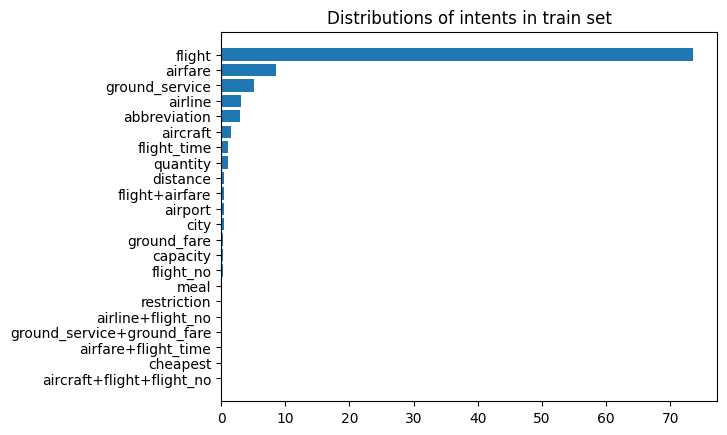

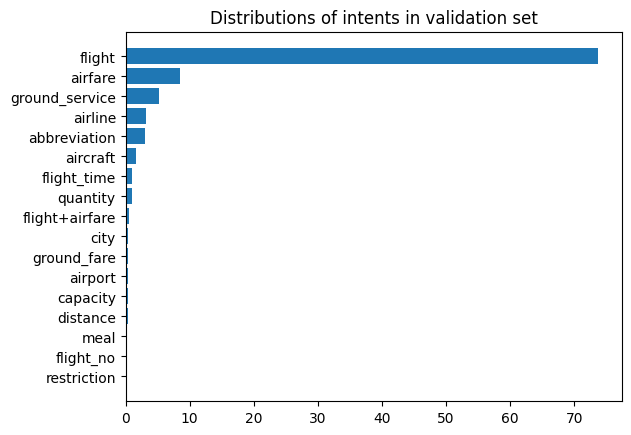

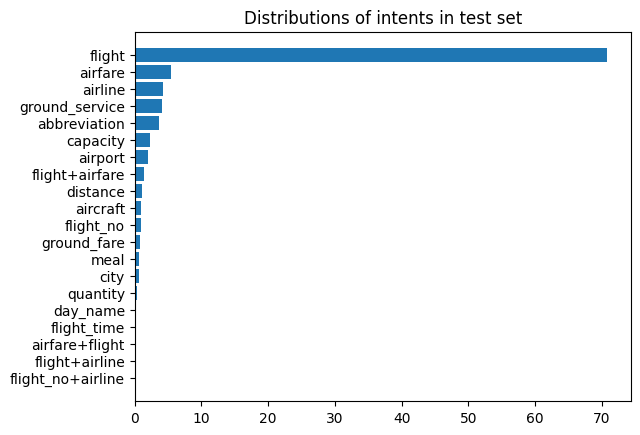

In [ ]:
atis = RawDatasetManager('ATIS', data_dir=atis_dir)
print_dataset_stats(atis)

===== SNIPS =====

TOTAL size:  14484
TRAIN size: 13084 [~90.33% of total]
VALIDATION size: 700 [~4.83% of total]
TEST size: 700 [~4.83% of total]

TRAIN VOCAB size:  11418

TOTAL unique intents:  7
TRAIN unique intents: 7
VALIDATION unique intents: 7
TEST unique intents: 7
Intents present in test, but not in train and validation: 0

TOTAL unique slots:  72
TRAIN unique slots: 72
VALIDATION unique slots: 70
TEST unique slots: 70
Slots present in test, but not in train and validation: 0



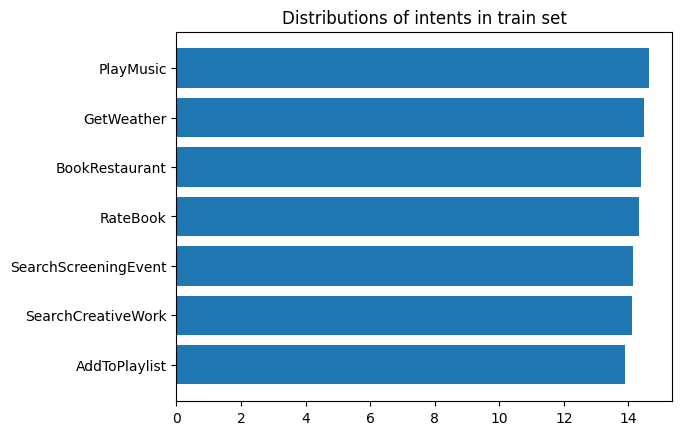

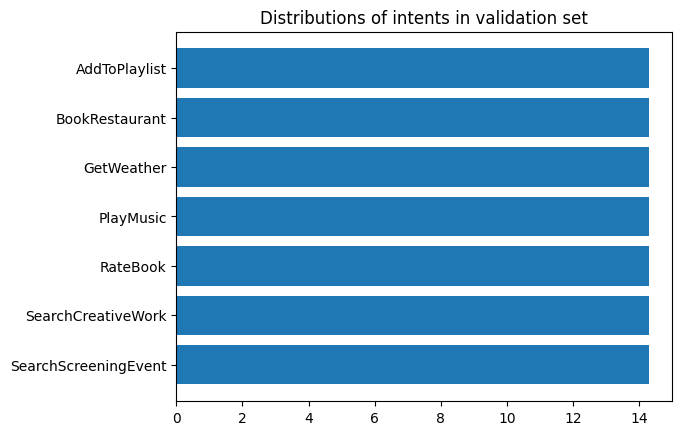

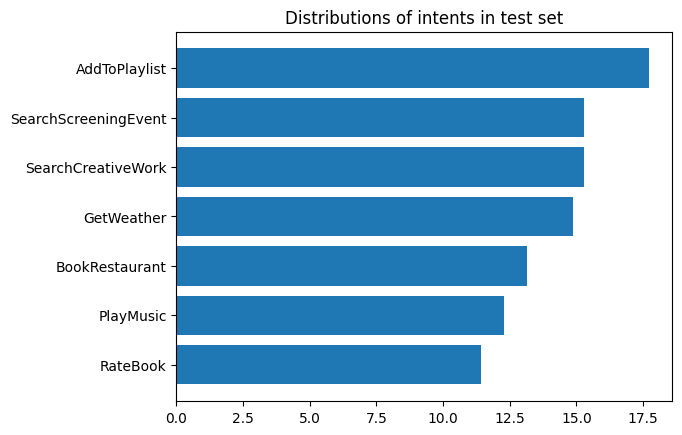

In [ ]:
snips = RawDatasetManager('SNIPS', data_dir=snips_dir)
print_dataset_stats(snips)

# Common utility functions
In this section I define some functions and utilities that are common to some parts of this notebook (like evaluating, plotting and logging).

## Weight initialization for network layers

In [ ]:
def init_weights(mat):
  for m in mat.modules():
    if type(m) in [nn.GRU, nn.LSTM, nn.RNN]:
      for name, param in m.named_parameters():
        if 'weight_ih' in name:
          for idx in range(4):
            mul = param.shape[0]//4
            torch.nn.init.xavier_uniform_(param[idx*mul:(idx+1)*mul])
        elif 'weight_hh' in name:
          for idx in range(4):
            mul = param.shape[0]//4
            torch.nn.init.orthogonal_(param[idx*mul:(idx+1)*mul])
        elif 'bias' in name:
            param.data.fill_(0)
    else:
      if type(m) in [nn.Linear]:
        torch.nn.init.uniform_(m.weight, -0.01, 0.01)
        if m.bias != None:
          m.bias.data.fill_(0.01)

## CoNLL evaluation

In [ ]:
import re

"""
Modified version of https://pypi.org/project/conlleval/
"""


def stats():
    return {'cor': 0, 'hyp': 0, 'ref': 0}


def evaluate(ref, hyp, otag='O'):
    # evaluation for NLTK
    aligned = align_hyp(ref, hyp)
    return conlleval(aligned, otag=otag)


def align_hyp(ref, hyp):
    # align references and hypotheses for evaluation
    # add last element of token tuple in hyp to ref
    if len(ref) != len(hyp):
        raise ValueError("Size Mismatch: ref: {} & hyp: {}".format(len(ref), len(hyp)))

    out = []
    for i in range(len(ref)):
        if len(ref[i]) != len(hyp[i]):
            raise ValueError("Size Mismatch: ref: {} & hyp: {}".format(len(ref), len(hyp)))
        out.append([(*ref[i][j], hyp[i][j][-1]) for j in range(len(ref[i]))])
    return out


def conlleval(data, otag='O'):
    # token, segment & class level counts for TP, TP+FP, TP+FN
    tok = stats()
    seg = stats()
    # cls = {}

    for sent in data:

        prev_ref = otag      # previous reference label
        prev_hyp = otag      # previous hypothesis label
        prev_ref_iob = None  # previous reference label IOB
        prev_hyp_iob = None  # previous hypothesis label IOB

        in_correct = False  # currently processed chunks is correct until now

        for token in sent:

            hyp_iob, hyp = parse_iob(token[-1])
            ref_iob, ref = parse_iob(token[-2])

            ref_e = is_eoc(ref, ref_iob, prev_ref, prev_ref_iob, otag)
            hyp_e = is_eoc(hyp, hyp_iob, prev_hyp, prev_hyp_iob, otag)

            ref_b = is_boc(ref, ref_iob, prev_ref, prev_ref_iob, otag)
            hyp_b = is_boc(hyp, hyp_iob, prev_hyp, prev_hyp_iob, otag)

            # if not cls.get(ref) and ref:
            #     cls[ref] = stats()

            # if not cls.get(hyp) and hyp:
            #     cls[hyp] = stats()

            # segment-level counts
            if in_correct:
                if ref_e and hyp_e and prev_hyp == prev_ref:
                    in_correct = False
                    seg['cor'] += 1
                    # cls[prev_ref]['cor'] += 1

                elif ref_e != hyp_e or hyp != ref:
                    in_correct = False

            if ref_b and hyp_b and hyp == ref:
                in_correct = True

            if ref_b:
                seg['ref'] += 1
                # cls[ref]['ref'] += 1

            if hyp_b:
                seg['hyp'] += 1
                # cls[hyp]['hyp'] += 1

            # token-level counts
            if ref == hyp and ref_iob == hyp_iob:
                tok['cor'] += 1

            tok['ref'] += 1

            prev_ref = ref
            prev_hyp = hyp
            prev_ref_iob = ref_iob
            prev_hyp_iob = hyp_iob

        if in_correct:
            seg['cor'] += 1
            # cls[prev_ref]['cor'] += 1

    return summarize(seg)


def parse_iob(t):
    m = re.match(r'^([^-]*)-(.*)$', t)
    return m.groups() if m else (t, None)


def is_boc(lbl, iob, prev_lbl, prev_iob, otag='O'):
    """
    is beginning of a chunk
    supports: IOB, IOBE, BILOU schemes
        - {E,L} --> last
        - {S,U} --> unit
    :param lbl: current label
    :param iob: current iob
    :param prev_lbl: previous label
    :param prev_iob: previous iob
    :param otag: out-of-chunk label
    :return:
    """
    boc = False

    boc = True if iob in ['B', 'S', 'U'] else boc
    boc = True if iob in ['E', 'L'] and prev_iob in ['E', 'L', 'S', otag] else boc
    boc = True if iob == 'I' and prev_iob in ['S', 'L', 'E', otag] else boc

    boc = True if lbl != prev_lbl and iob != otag and iob != '.' else boc

    # these chunks are assumed to have length 1
    boc = True if iob in ['[', ']'] else boc

    return boc


def is_eoc(lbl, iob, prev_lbl, prev_iob, otag='O'):
    """
    is end of a chunk
    supports: IOB, IOBE, BILOU schemes
        - {E,L} --> last
        - {S,U} --> unit
    :param lbl: current label
    :param iob: current iob
    :param prev_lbl: previous label
    :param prev_iob: previous iob
    :param otag: out-of-chunk label
    :return:
    """
    eoc = False

    eoc = True if iob in ['E', 'L', 'S', 'U'] else eoc
    eoc = True if iob == 'B' and prev_iob in ['B', 'I'] else eoc
    eoc = True if iob in ['S', 'U'] and prev_iob in ['B', 'I'] else eoc

    eoc = True if iob == otag and prev_iob in ['B', 'I'] else eoc

    eoc = True if lbl != prev_lbl and iob != otag and prev_iob != '.' else eoc

    # these chunks are assumed to have length 1
    eoc = True if iob in ['[', ']'] else eoc

    return eoc


def score(cor_cnt, hyp_cnt, ref_cnt):
    # precision
    p = 1 if hyp_cnt == 0 else cor_cnt / hyp_cnt
    # recall
    r = 0 if ref_cnt == 0 else cor_cnt / ref_cnt
    # f-measure (f1)
    f = 0 if p+r == 0 else (2*p*r)/(p+r)
    return {"p": p, "r": r, "f": f, "s": ref_cnt}


def summarize(seg):
    # class-level
    # res = {lbl: score(cls[lbl]['cor'], cls[lbl]['hyp'], cls[lbl]['ref']) for lbl in set(cls.keys())}
    # micro
    res = {"total": score(seg.get('cor', 0), seg.get('hyp', 0), seg.get('ref', 0))}
    return res


def read_corpus_conll(corpus_file, fs="\t"):
    """
    read corpus in CoNLL format
    :param corpus_file: corpus in conll format
    :param fs: field separator
    :return: corpus
    """
    featn = None  # number of features for consistency check
    sents = []  # list to hold words list sequences
    words = []  # list to hold feature tuples

    for line in open(corpus_file):
        line = line.strip()
        if len(line.strip()) > 0:
            feats = tuple(line.strip().split(fs))
            if not featn:
                featn = len(feats)
            elif featn != len(feats) and len(feats) != 0:
                raise ValueError("Unexpected number of columns {} ({})".format(len(feats), featn))

            words.append(feats)
        else:
            if len(words) > 0:
                sents.append(words)
                words = []
    return sents


def get_chunks(corpus_file, fs="\t", otag="O"):
    sents = read_corpus_conll(corpus_file, fs=fs)
    return set([parse_iob(token[-1])[1] for sent in sents for token in sent if token[-1] != otag])

## Plotting and showing results

In [ ]:
def show_training_results(params, lang):
  n_runs = len(params)

  intent_accs = np.asarray([run_params['intent_score']for run_params in params])
  slot_f1s = np.asarray([run_params['slot_score']for run_params in params])

  print(f'Intent accuracy: {round(intent_accs.mean(), 3)} +- {round(intent_accs.std(), 3)}')
  print(f'Slot F1: {round(slot_f1s.mean(), 3)} +- {round(slot_f1s.std(), 3)}')
  print()

  # Plots related to result with higher F1 slot score
  run_to_plot = np.argmax(slot_f1s)

  # Losses
  sampled_epochs = params[run_to_plot]['sampled_epochs']
  # Total
  train_losses = params[run_to_plot]['loss_dict_train']['total']
  valid_losses = params[run_to_plot]['loss_dict_valid']['total']

  plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
  plt.title('Train and Validation Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.plot(sampled_epochs, train_losses, label='Train loss')
  plt.plot(sampled_epochs, valid_losses, label='Validation loss')
  plt.legend()
  plt.show()

  # Intent
  train_losses = params[run_to_plot]['loss_dict_train']['intent']
  valid_losses = params[run_to_plot]['loss_dict_valid']['intent']

  plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
  plt.title('Train and Validation Intent Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.plot(sampled_epochs, train_losses, label='Train loss')
  plt.plot(sampled_epochs, valid_losses, label='Validation loss')
  plt.legend()
  plt.show()

  # Slot
  train_losses = params[run_to_plot]['loss_dict_train']['slot']
  valid_losses = params[run_to_plot]['loss_dict_valid']['slot']

  plt.figure(num = 3, figsize=(8, 5)).patch.set_facecolor('white')
  plt.title('Train and Validation Slot Losses')
  plt.ylabel('Loss')
  plt.xlabel('Epochs')
  plt.plot(sampled_epochs, train_losses, label='Train loss')
  plt.plot(sampled_epochs, valid_losses, label='Validation loss')
  plt.legend()
  plt.show()

  # Confusion matrices
  conf_matrix_slot = params[run_to_plot]['conf_matrix_slot']
  conf_matrix_intent = params[run_to_plot]['conf_matrix_intent']

  def plot(conf_matrix, labels, figsize):
    fig, ax = plt.subplots(figsize=figsize)
    d = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=labels)
    d.plot(xticks_rotation='vertical', ax=ax, colorbar=False, cmap='Blues')

  plot(conf_matrix_intent, list(lang.intent2id.keys()), (10, 10))
  plot(conf_matrix_slot, list(lang.slot2id.keys()), (80, 80))

# Baseline
The baseline for this project is borrowed by the model defined in Lab 10, and only slightly adapted to use my dataset manager.

## Language class to handle vocabulary
Since neural Netwoks in Pytorch, as in other libraries, work with numbers and vectors, here I prepare functions to convert all necessary data to the right format.

In [ ]:
class Lang():
  def __init__(self, raw_dataset_manager: RawDatasetManager, cutoff=0):
    train = raw_dataset_manager.train
    validation = raw_dataset_manager.valid
    test = raw_dataset_manager.test
    all = raw_dataset_manager.get_all()

    words = [word for item in train for word in item.utterance.split()] # no set because of potential cutoff usage
    intents = set([item.intent for item in all])
    slots = set([slot for item in all for slot in item.slots.split()])

    self.word2id = self._w2id(words, cutoff=cutoff, unk=True)
    self.slot2id = self._lab2id(slots)
    self.intent2id = self._lab2id(intents, pad=False)
    self.id2word = {v:k for k, v in self.word2id.items()}
    self.id2slot = {v:k for k, v in self.slot2id.items()}
    self.id2intent = {v:k for k, v in self.intent2id.items()}

  def _w2id(self, elements, cutoff=None, unk=True):
    vocab = {pad_token: pad_id}
    if unk:
      vocab[unk_token] = len(vocab)
    count = Counter(elements)
    for k, v in count.items():
      if v > cutoff:
        vocab[k] = len(vocab)
    return vocab

  def _lab2id(self, elements, pad=True):
    vocab = {}
    if pad:
      vocab[pad_token] = pad_id
    for elem in elements:
      vocab[elem] = len(vocab)
    return vocab


Let's take a quick look at how the data looks like, and also at how big the vocabulary of the training set is.

In [ ]:
for raw_dataset_manager in [RawDatasetManager('ATIS', atis_dir), RawDatasetManager('SNIPS', snips_dir)]:
  lang = Lang(raw_dataset_manager)
  print(f'{raw_dataset_manager.name} vocabulary size: {len(lang.word2id)-2}') # do not consider [PAD] and [UNK]
  print('Example of word2id mapping: ', list(lang.word2id.items())[:4])
  print('Example of id2word mapping: ', list(lang.id2word.items())[:4])
  print('Example of slot2id mapping: ', list(lang.slot2id.items())[:4])
  print('Example of id2slot mapping: ', list(lang.id2slot.items())[:4])
  print('Example of intent2id mapping: ', list(lang.intent2id.items())[:4])
  print('Example of id2intent mapping: ', list(lang.id2intent.items())[:4])
  print()

File data/ATIS/valid.json not found
Performing train/validation split... Done

ATIS vocabulary size: 861
Example of word2id mapping:  [('[PAD]', 0), ('[UNK]', 1), ('what', 2), ('type', 3)]
Example of id2word mapping:  [(0, '[PAD]'), (1, '[UNK]'), (2, 'what'), (3, 'type')]
Example of slot2id mapping:  [('[PAD]', 0), ('B-arrive_time.start_time', 1), ('B-toloc.city_name', 2), ('I-depart_date.day_name', 3)]
Example of id2slot mapping:  [(0, '[PAD]'), (1, 'B-arrive_time.start_time'), (2, 'B-toloc.city_name'), (3, 'I-depart_date.day_name')]
Example of intent2id mapping:  [('flight', 0), ('flight_no', 1), ('day_name', 2), ('ground_service+ground_fare', 3)]
Example of id2intent mapping:  [(0, 'flight'), (1, 'flight_no'), (2, 'day_name'), (3, 'ground_service+ground_fare')]

SNIPS vocabulary size: 11418
Example of word2id mapping:  [('[PAD]', 0), ('[UNK]', 1), ('listen', 2), ('to', 3)]
Example of id2word mapping:  [(0, '[PAD]'), (1, '[UNK]'), (2, 'listen'), (3, 'to')]
Example of slot2id mapping:

## Custom Pytorch dataset

In [ ]:
class IntentsAndSlots (data.Dataset):
    # Mandatory methods are __init__, __len__ and __getitem__
    def __init__(self, raw_dataset: RawDataset, lang: Lang, unk=unk_token):
        self.utterances = []
        self.intents = []
        self.slots = []
        self.unk = unk

        for x in raw_dataset:
            self.utterances.append(x.utterance)
            self.slots.append(x.slots)
            self.intents.append(x.intent)

        self.utt_ids = self.mapping_seq(self.utterances, lang.word2id)
        self.slot_ids = self.mapping_seq(self.slots, lang.slot2id)
        self.intent_ids = self.mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
        return len(self.utterances)

    def __getitem__(self, idx):
        utt = torch.Tensor(self.utt_ids[idx])
        slots = torch.Tensor(self.slot_ids[idx])
        intent = self.intent_ids[idx]
        sample = {'utterance': utt, 'slots': slots, 'intent': intent}
        return sample

    # Auxiliary methods

    def mapping_lab(self, data, mapper):
        return [mapper[x] if x in mapper else mapper[self.unk] for x in data]

    def mapping_seq(self, data, mapper): # Map sequences to number
        res = []
        for seq in data:
            tmp_seq = []
            for x in seq.split():
                if x in mapper:
                    tmp_seq.append(mapper[x])
                else:
                    tmp_seq.append(mapper[self.unk])
            res.append(tmp_seq)
        return res

def collate_fn(data):

  def merge(sequences):
    '''
    merge from batch * sent_len to batch * max_len
    '''
    lengths = [len(seq) for seq in sequences]
    max_len = 1 if max(lengths)==0 else max(lengths)
    # Pad token is zero in our case
    # So we create a matrix full of pad_id (i.e. 0) with the shape
    # batch_size X maximum length of a sequence
    padded_seqs = torch.LongTensor(len(sequences),max_len).fill_(pad_id)
    for i, seq in enumerate(sequences):
      end = lengths[i]
      padded_seqs[i, :end] = seq # We copy each sequence into the matrix
    padded_seqs = padded_seqs.detach()  # We remove these tensors from the computational graph
    return padded_seqs, lengths

  # Sort data by seq lengths
  data.sort(key=lambda x: len(x['utterance']), reverse=True)
  new_item = {}
  for key in data[0].keys():
    new_item[key] = [d[key] for d in data]
  # We just need one length for packed pad seq, since len(utt) == len(slots)
  src_utt, _ = merge(new_item['utterance'])
  y_slots, y_lengths = merge(new_item["slots"])
  intent = torch.LongTensor(new_item["intent"])

  src_utt = src_utt.to(device) # We load the Tensor on our seleceted device
  y_slots = y_slots.to(device)
  intent = intent.to(device)
  y_lengths = torch.LongTensor(y_lengths).to(device)

  new_item["utterances"] = src_utt
  new_item["intents"] = intent
  new_item["y_slots"] = y_slots
  new_item["slots_len"] = y_lengths
  return new_item

## Model architecture

In [ ]:
class ModelIAS(nn.Module):

  def __init__(self, hid_size, out_slot, out_int, emb_size, vocab_len, n_layer=1, pad_index=0):
    super(ModelIAS, self).__init__()
    # hid_size = Hidden size
    # out_slot = number of slots (output size for slot filling)
    # out_int = number of intents (ouput size for intent class)
    # emb_size = word embedding size

    self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_index)

    self.utt_encoder = nn.LSTM(emb_size, hid_size, n_layer, bidirectional=False)
    self.slot_out = nn.Linear(hid_size, out_slot)
    self.intent_out = nn.Linear(hid_size, out_int)
    self.dropout = nn.Dropout(0.1)

  def forward(self, utterance, seq_lengths):
    # utterance.size() = batch_size X seq_len
    utt_emb = self.embedding(utterance) # utt_emb.size() = batch_size X seq_len X emb_size
    utt_emb = utt_emb.permute(1,0,2) # we need seq len first -> seq_len X batch_size X emb_size

    # pack_padded_sequence avoid computation over pad tokens reducing the computational cost

    packed_input = pack_padded_sequence(utt_emb, seq_lengths.cpu().numpy())
    # Process the batch
    packed_output, (last_hidden, cell) = self.utt_encoder(packed_input)
    # Unpack the sequence
    utt_encoded, input_sizes = pad_packed_sequence(packed_output)
    # Get the last hidden state
    last_hidden = last_hidden[-1,:,:]
    # Compute slot logits
    slots = self.slot_out(utt_encoded)
    # Compute intent logits
    intent = self.intent_out(last_hidden)

    # Slot size: seq_len, batch size, calsses
    slots = slots.permute(1,2,0) # We need this for computing the loss
    # Slot size: batch_size, classes, seq_len
    return slots, intent

## Training and evaluation procedures

In [ ]:
def train_loop(data, optimizer, criterion_slots, criterion_intents, model):
  model.train()
  loss_dict = {'intent': [], 'slot': [], 'total': []}
  intent_loss_array = []
  slot_loss_array = []
  for sample in data:
    optimizer.zero_grad() # Zeroing the gradient
    slots, intent = model(sample['utterances'], sample['slots_len'])
    loss_intent = criterion_intents(intent, sample['intents'])
    loss_slot = criterion_slots(slots, sample['y_slots'])
    loss = loss_intent + loss_slot
    loss_dict['total'].append(loss.item())
    loss_dict['intent'].append(loss_intent.item())
    loss_dict['slot'].append(loss_slot.item())
    loss.backward() # Compute the gradient, deleting the computational graph
    optimizer.step() # Update the weights
  return loss_dict

def eval_loop(data, criterion_slots, criterion_intents, model, lang):
  model.eval()
  loss_dict = {'intent': [], 'slot': [], 'total': []}

  ref_intents = []
  hyp_intents = []

  ref_slots = []
  hyp_slots = []
  with torch.no_grad(): # It used to avoid the creation of computational graph
    for sample in data:
      slots, intents = model(sample['utterances'], sample['slots_len'])
      loss_intent = criterion_intents(intents, sample['intents'])
      loss_slot = criterion_slots(slots, sample['y_slots'])
      loss = loss_intent + loss_slot
      loss_dict['total'].append(loss.item())
      loss_dict['intent'].append(loss_intent.item())
      loss_dict['slot'].append(loss_slot.item())
      # Intent inference
      # Get the highest probable class
      out_intents = [lang.id2intent[x]
                      for x in torch.argmax(intents, dim=1).tolist()]
      gt_intents = [lang.id2intent[x] for x in sample['intents'].tolist()]
      ref_intents.extend(gt_intents)
      hyp_intents.extend(out_intents)

      # Slot inference
      output_slots = torch.argmax(slots, dim=1)
      for id_seq, seq in enumerate(output_slots):
        length = sample['slots_len'].tolist()[id_seq]
        utt_ids = sample['utterance'][id_seq][:length].tolist()
        gt_ids = sample['y_slots'][id_seq].tolist()
        gt_slots = [lang.id2slot[elem] for elem in gt_ids[:length]]
        utterance = [lang.id2word[elem] for elem in utt_ids]
        to_decode = seq[:length].tolist()
        ref_slots.append([(utterance[id_el], elem) for id_el, elem in enumerate(gt_slots)])
        tmp_seq = []
        for id_el, elem in enumerate(to_decode):
          tmp_seq.append((utterance[id_el], lang.id2slot[elem]))
        hyp_slots.append(tmp_seq)

  results = evaluate(ref_slots, hyp_slots)

  report_intent = classification_report(ref_intents, hyp_intents,
                                        zero_division=False, output_dict=True)

  # Confusion matrices
  conf_matrix_slot = confusion_matrix([token[1] for sent in ref_slots for token in sent], [token[1] for sent in hyp_slots for token in sent],labels=list(lang.slot2id.keys()))
  conf_matrix_intent = confusion_matrix(ref_intents, hyp_intents,labels=list(lang.intent2id.keys()))

  return results, report_intent, loss_dict, conf_matrix_slot, conf_matrix_intent


def train(model, n_epochs: int, patience: int, lang: Lang, train_loader: DataLoader, validation_loader: DataLoader, optimizer, criterion_intents, criterion_slots):
  loss_dict_train = {'intent': [], 'slot': [], 'total': []}
  loss_dict_validation = {'intent': [], 'slot': [], 'total': []}
  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):
    loss_dict = train_loop(train_loader, optimizer, criterion_slots,
                      criterion_intents, model)
    if x % 5 == 0:
      sampled_epochs.append(x)
      loss_dict_train['total'].append(np.asarray(loss_dict['total']).mean())
      loss_dict_train['intent'].append(np.asarray(loss_dict['intent']).mean())
      loss_dict_train['slot'].append(np.asarray(loss_dict['slot']).mean())

      results_dev, intent_res, loss_dict, _, _ = eval_loop(validation_loader, criterion_slots,
                                                    criterion_intents, model, lang)

      loss_dict_validation['total'].append(np.asarray(loss_dict['total']).mean())
      loss_dict_validation['intent'].append(np.asarray(loss_dict['intent']).mean())
      loss_dict_validation['slot'].append(np.asarray(loss_dict['slot']).mean())

      f1 = results_dev['total']['f']

      if f1 > best_f1:
          best_f1 = f1
      else:
          patience -= 1
      if patience <= 0: # Early stoping with patient
          break # Not nice but it keeps the code clean

  return loss_dict_train, loss_dict_validation, sampled_epochs


def test(model, lang: Lang, test_loader: DataLoader, criterion_intents, criterion_slots,):
  results_test, intent_test, _, conf_matrix_slot, conf_matrix_intent = eval_loop(test_loader, criterion_slots,
                                            criterion_intents, model, lang)

  return intent_test['accuracy'], results_test['total']['f'], conf_matrix_slot, conf_matrix_intent


def train_multiple_runs(n_runs: int, n_epochs: int, patience: int, lang: Lang, train_loader: DataLoader, validation_loader: DataLoader, test_loader: DataLoader):
  params = []

  out_slot = len(lang.slot2id)
  out_int = len(lang.intent2id)
  vocab_len = len(lang.word2id)

  for run_id in range(n_runs):
    print(f'Training  #{run_id+1}')

    hid_size = 200
    emb_size = 300
    lr = 0.0001

    model = ModelIAS(hid_size, out_slot, out_int, emb_size, vocab_len, pad_index=pad_id).to(device)
    model.apply(init_weights)

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=pad_id)
    criterion_intents = nn.CrossEntropyLoss()

    loss_dict_train, loss_dict_validation, sampled_epochs = train(model, n_epochs, patience, lang, train_loader, validation_loader, optimizer, criterion_intents, criterion_slots)

    intent_score, slot_score, conf_matrix_slot, conf_matrix_intent = test(model, lang, test_loader, criterion_intents, criterion_slots)

    run_params = {}
    run_params['loss_dict_train'] = loss_dict_train
    run_params['loss_dict_valid'] = loss_dict_validation
    run_params['sampled_epochs'] = sampled_epochs
    run_params['intent_score'] = intent_score
    run_params['slot_score'] = slot_score
    run_params['conf_matrix_slot'] = conf_matrix_slot
    run_params['conf_matrix_intent'] = conf_matrix_intent
    params.append(run_params)

    print()

  return params

## Training and evaluating the model

### ATIS

In [ ]:
atis = RawDatasetManager('ATIS', atis_dir)
lang = Lang(atis)

train_dataset = IntentsAndSlots(atis.train, lang)
validation_dataset = IntentsAndSlots(atis.train, lang)
test_dataset = IntentsAndSlots(atis.test, lang)

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

params_atis_baseline = train_multiple_runs(
    n_runs=5,
    n_epochs=200,
    patience=5,
    lang=lang,
    train_loader=train_loader,
    validation_loader=validation_loader,
    test_loader=test_loader
)

File data/ATIS/valid.json not found
Performing train/validation split... Done

Training  #1


100%|██████████| 199/199 [03:42<00:00,  1.12s/it]



Training  #2


100%|██████████| 199/199 [03:15<00:00,  1.02it/s]



Training  #3


100%|██████████| 199/199 [03:13<00:00,  1.03it/s]



Training  #4


100%|██████████| 199/199 [03:13<00:00,  1.03it/s]



Training  #5


100%|██████████| 199/199 [03:12<00:00,  1.04it/s]


Intent accuracy: 0.941 +- 0.002
Slot F1: 0.926 +- 0.003



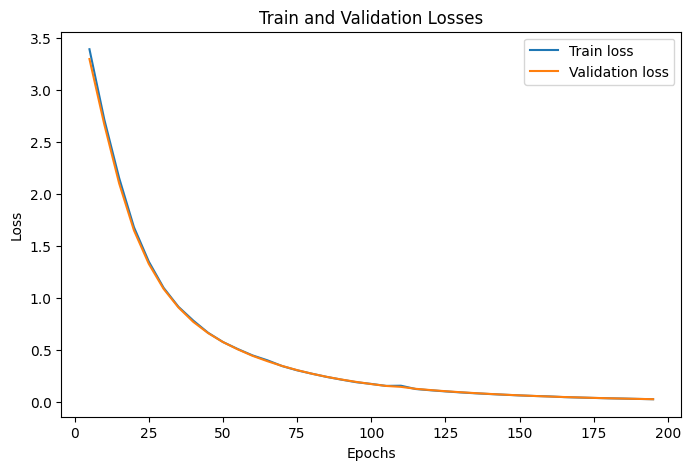

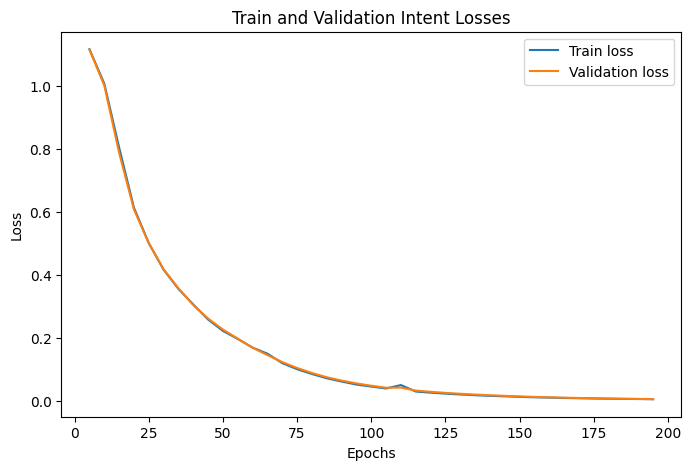

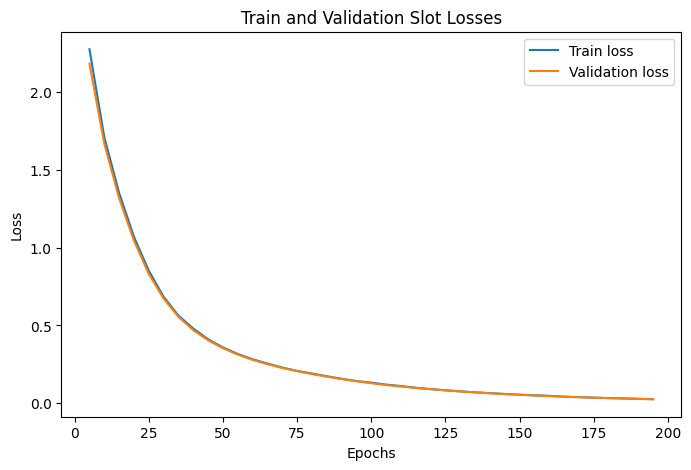

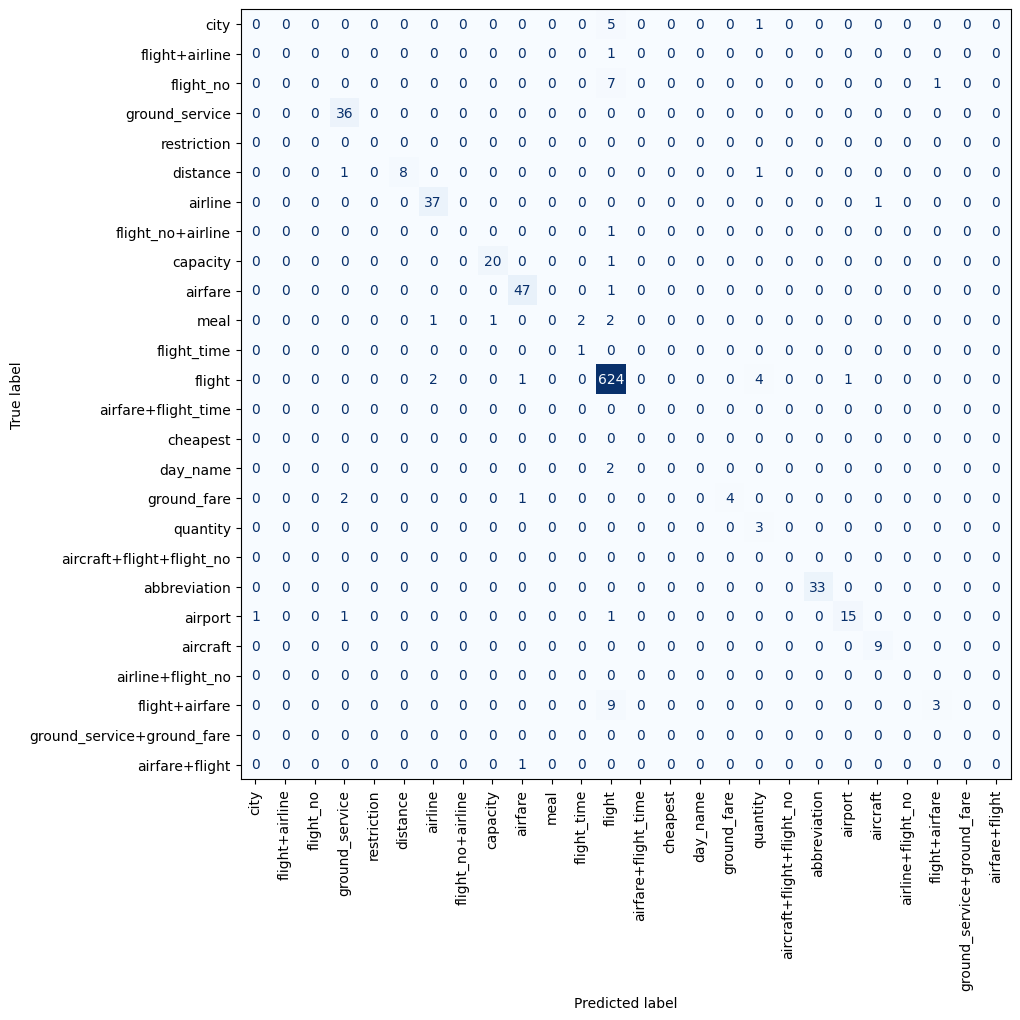

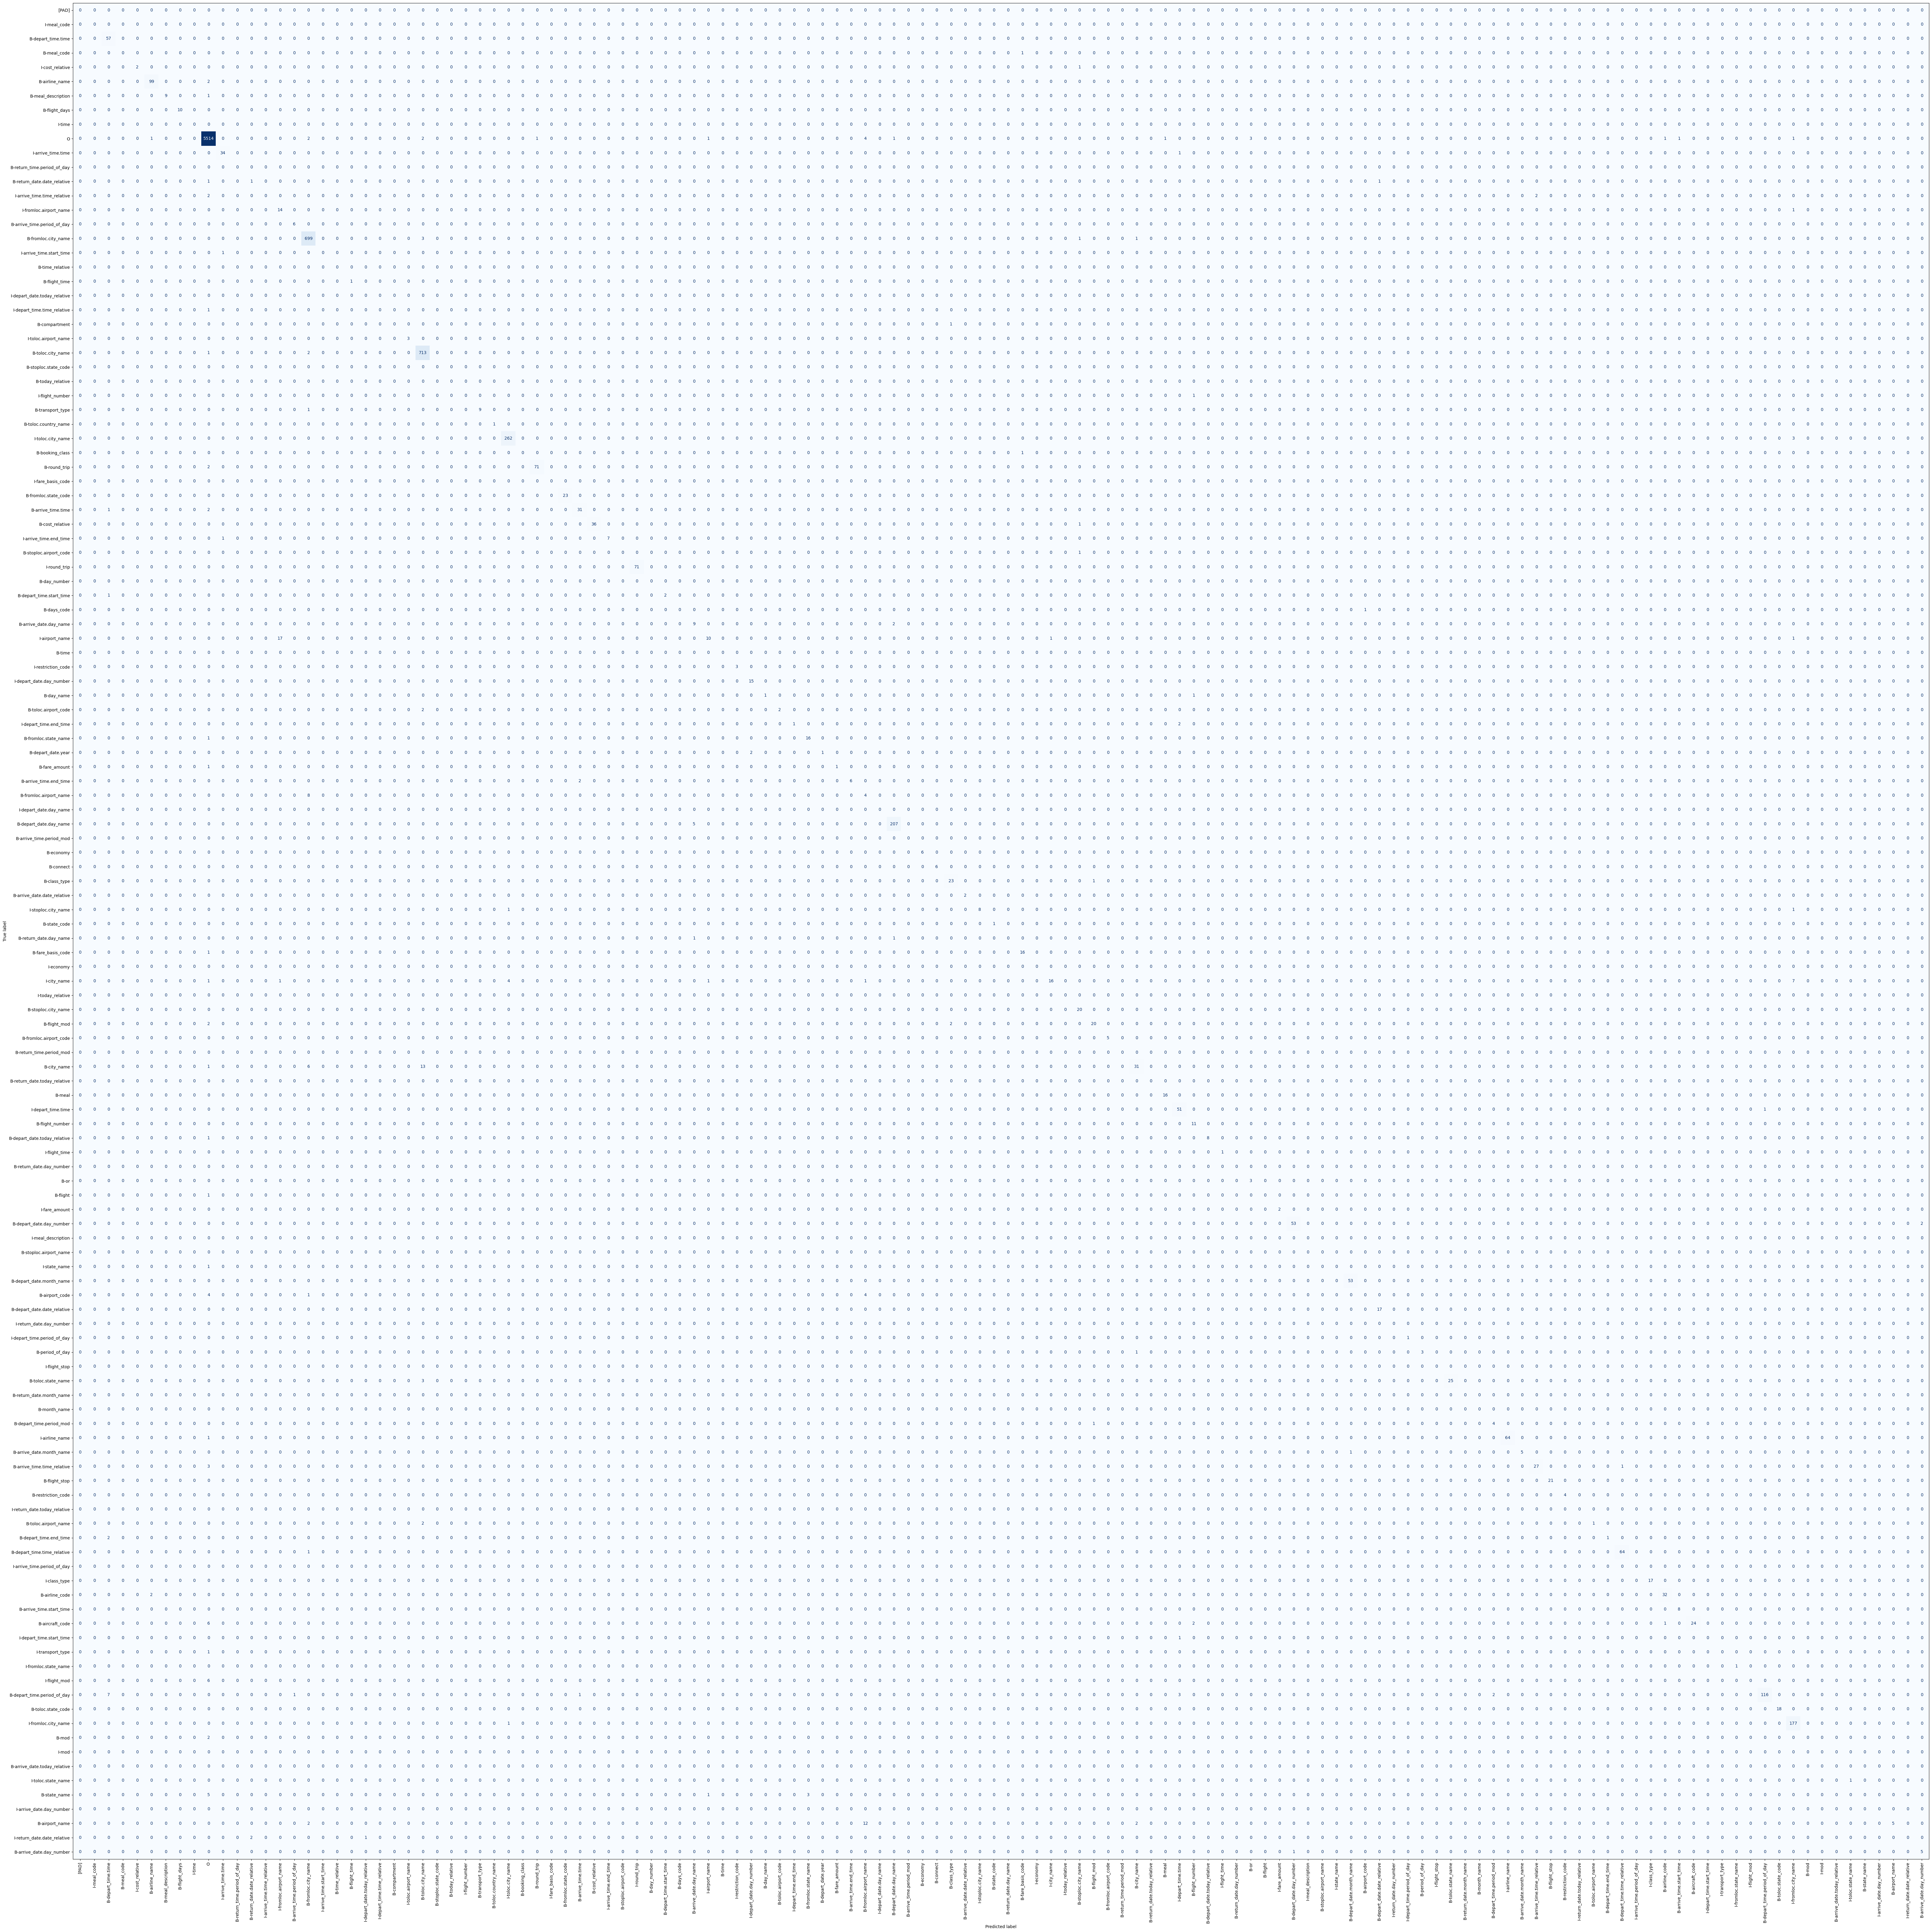

In [ ]:
show_training_results(params_atis_baseline, lang)

### SNIPS

In [ ]:
snips = RawDatasetManager('SNIPS', snips_dir)
lang = Lang(snips)

train_dataset = IntentsAndSlots(snips.train, lang)
validation_dataset = IntentsAndSlots(snips.train, lang)
test_dataset = IntentsAndSlots(snips.test, lang)

train_loader = DataLoader(train_dataset, batch_size=128, collate_fn=collate_fn,  shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=64, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, collate_fn=collate_fn)

params_snips_baseline = train_multiple_runs(
    n_runs=5,
    n_epochs=200,
    patience=5,
    lang=lang,
    train_loader=train_loader,
    validation_loader=validation_loader,
    test_loader=test_loader
)

Training  #1


 95%|█████████▍| 189/199 [07:59<00:25,  2.54s/it]



Training  #2


100%|██████████| 199/199 [08:17<00:00,  2.50s/it]



Training  #3


 95%|█████████▍| 189/199 [07:57<00:25,  2.53s/it]



Training  #4


 92%|█████████▏| 184/199 [07:45<00:37,  2.53s/it]



Training  #5


 82%|████████▏ | 164/199 [07:06<01:30,  2.60s/it]

Intent accuracy: 0.964 +- 0.005
Slot F1: 0.801 +- 0.006



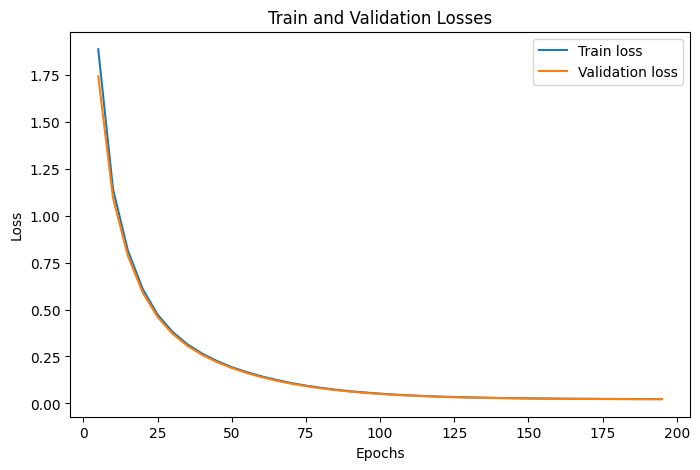

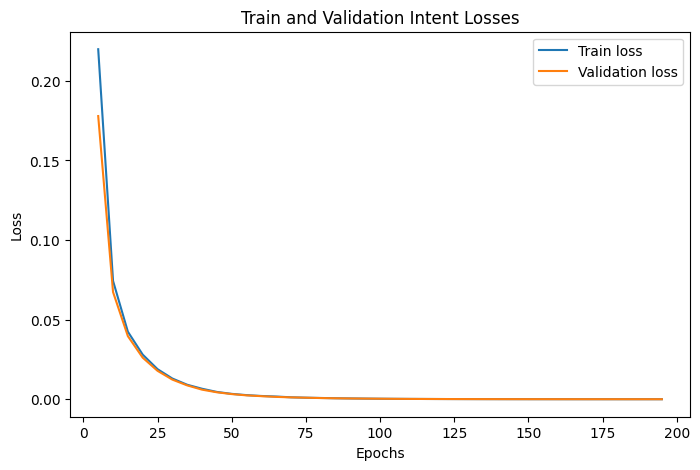

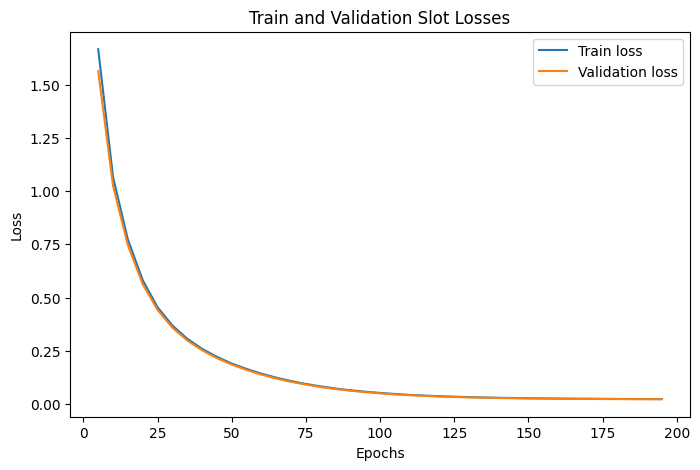

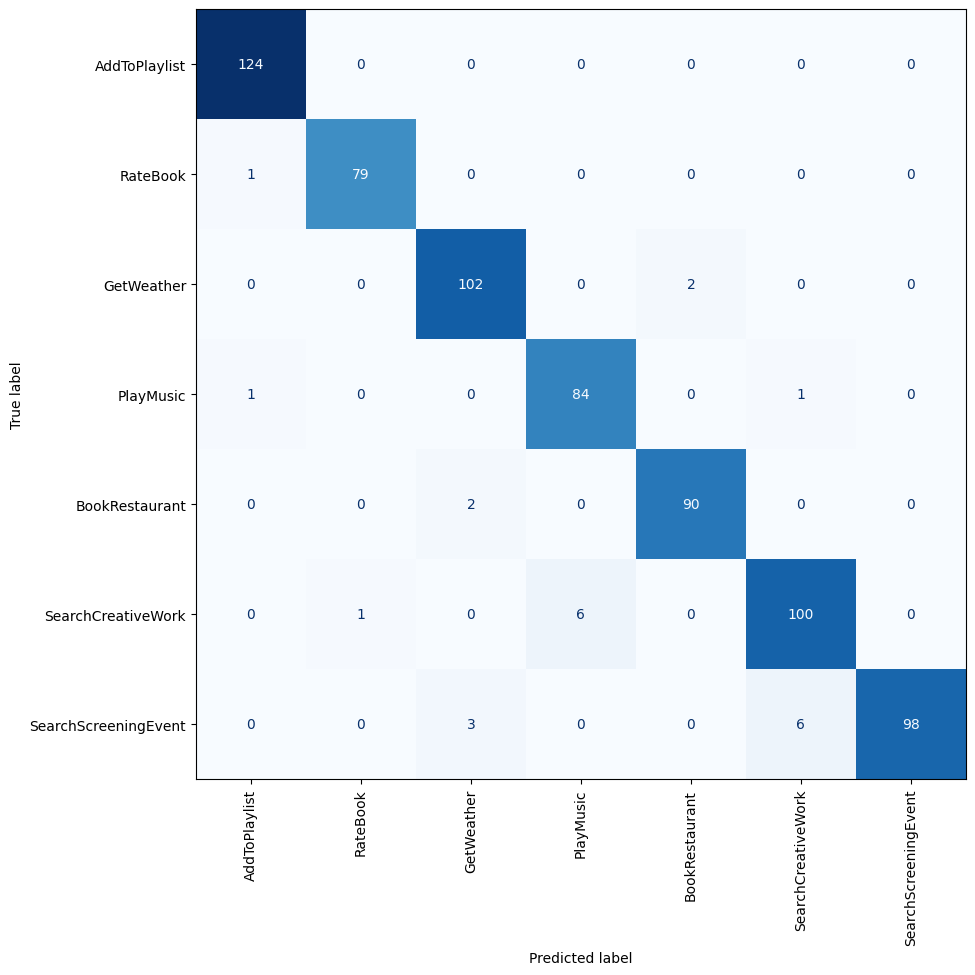

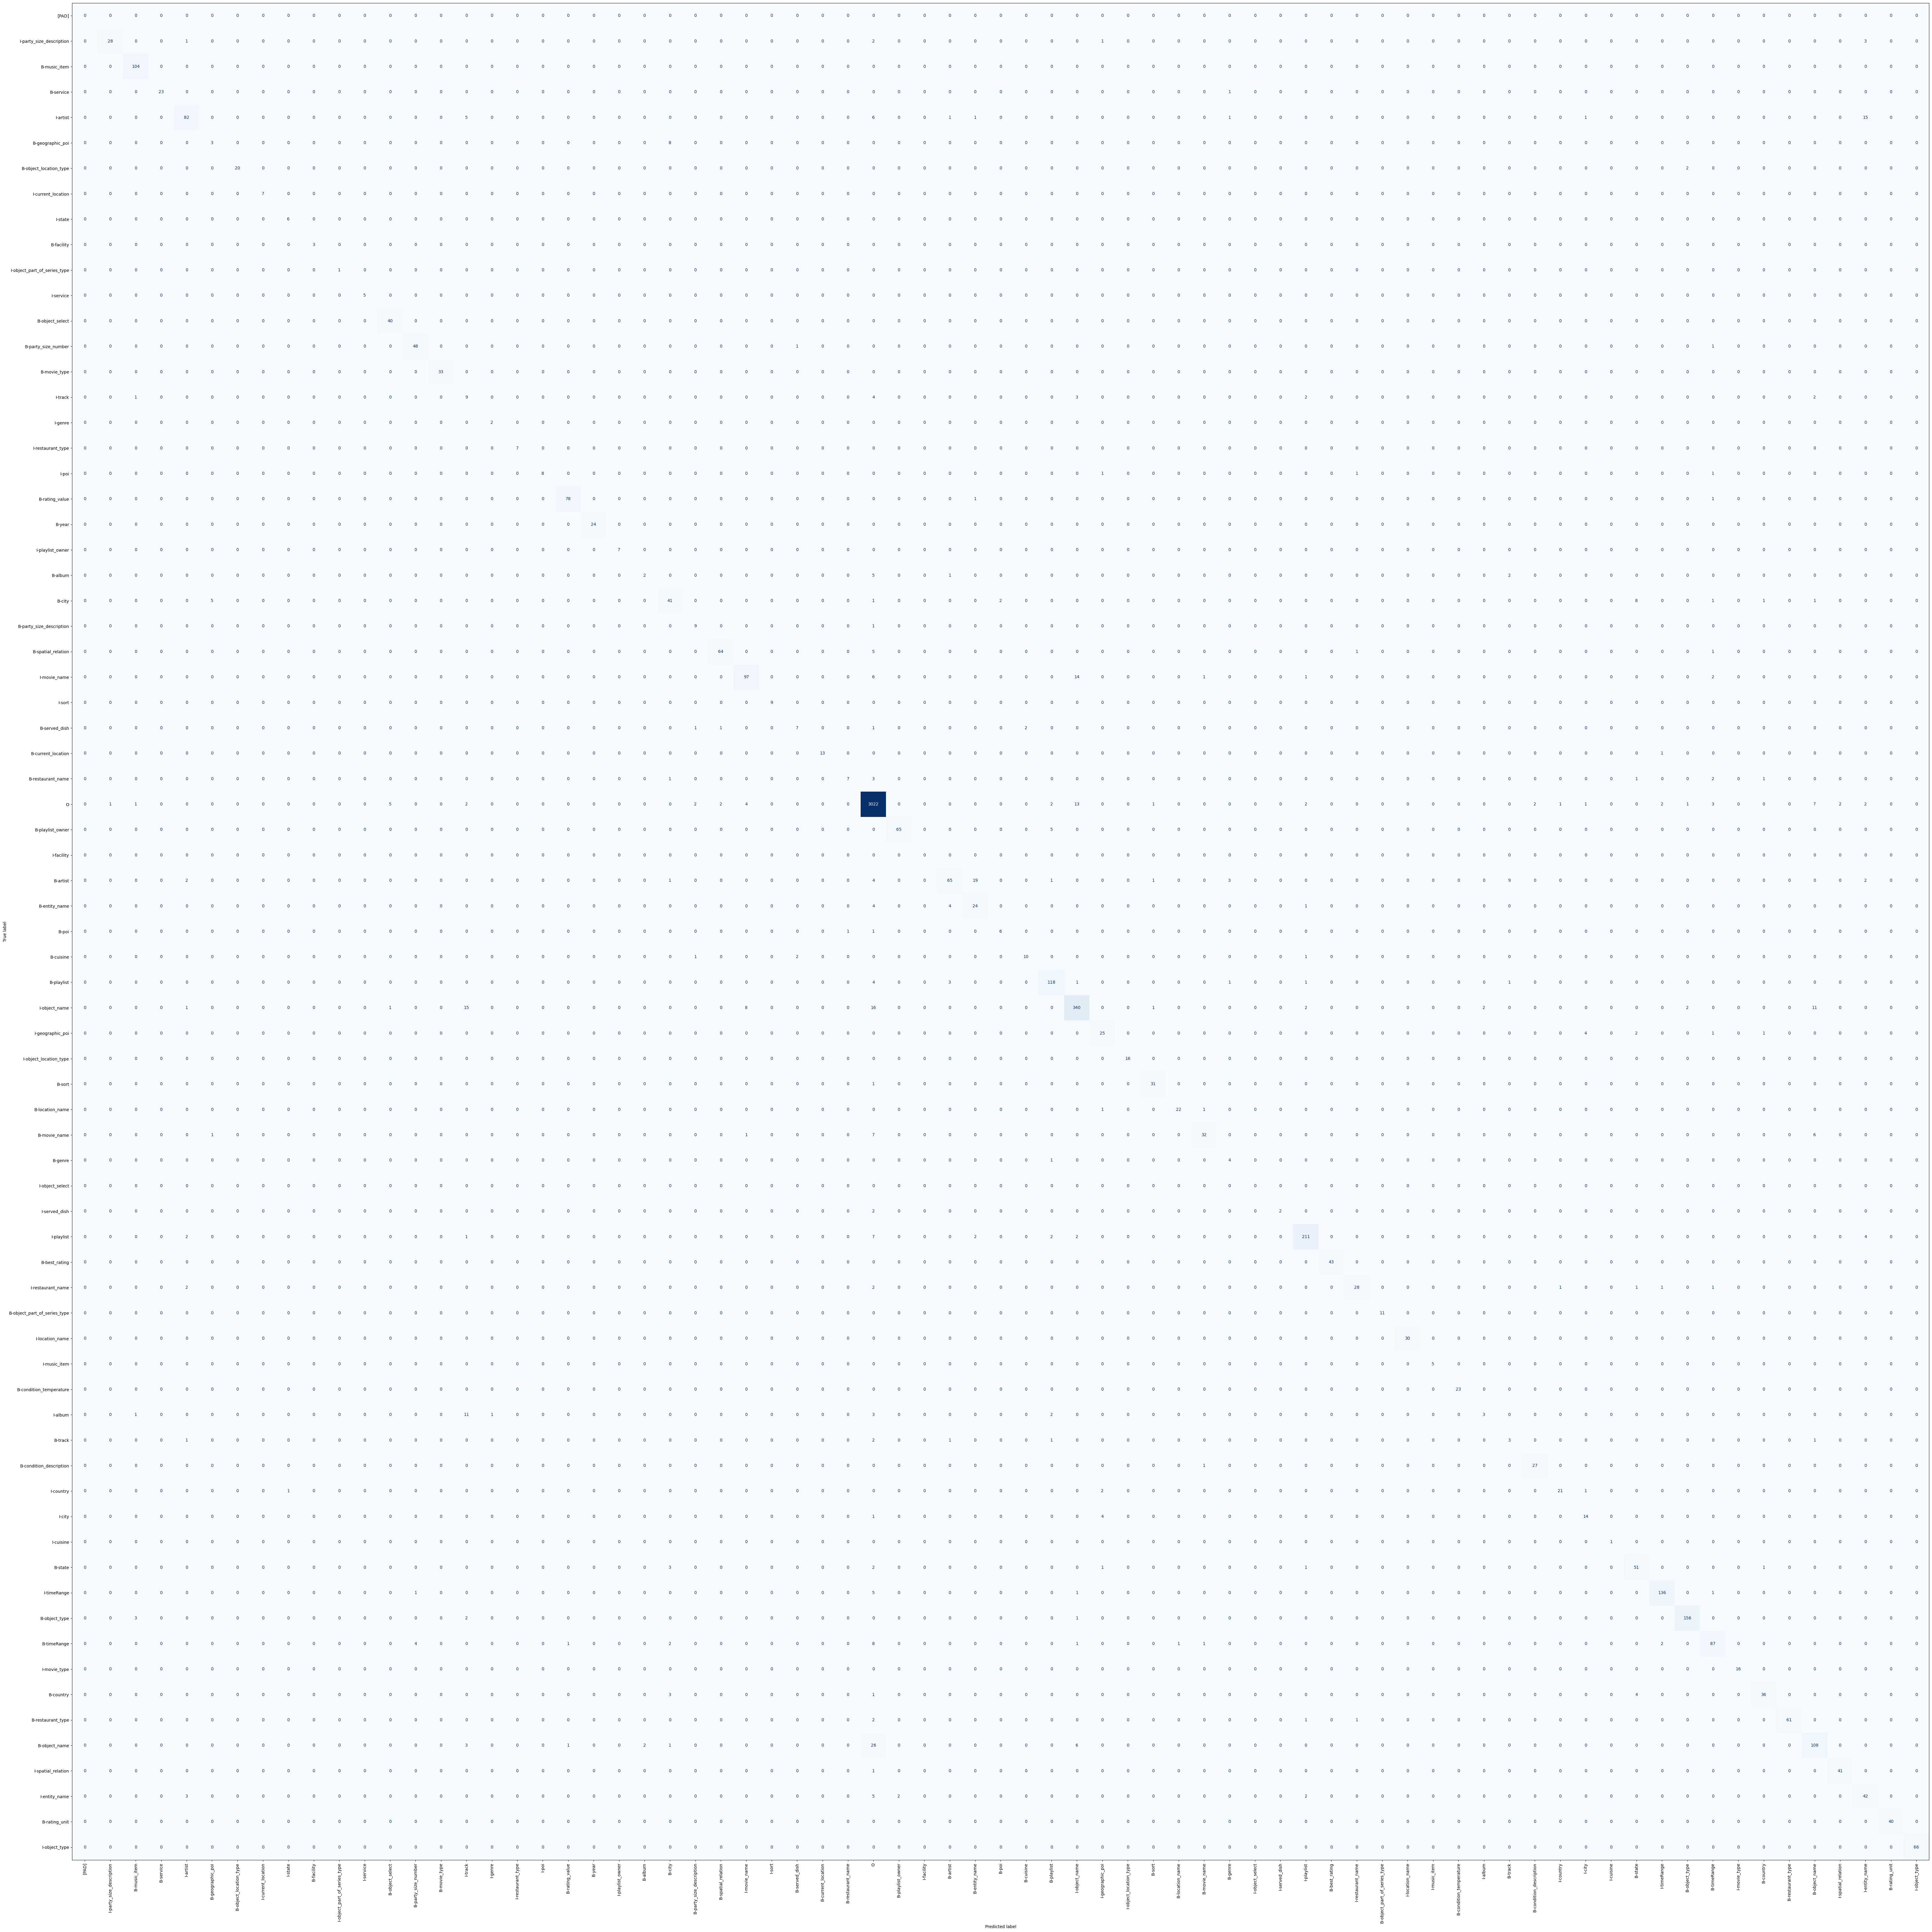

In [ ]:
show_training_results(params_snips_baseline, lang)

# BERT + Bi-Directional NLU mechanism

## Configuration
In this section, I simply define the name of the BERT model I want to use, together with its tokenizer.

In [ ]:
from transformers import BertTokenizer, BertModel

bert_model_name = 'bert-base-uncased'
bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name, do_lower_case=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## Custom BERT language class
In this section, I define a class that helps with mapping words into numbers (and vice-versa). I use the BERT tokenizer for the word vocabulary.

In [ ]:
class BERTLang():
  def __init__(self, raw_dataset_manager: RawDatasetManager, tokenizer: BertTokenizer):
    all = raw_dataset_manager.get_all()

    slots = all.get_slots_set()
    intents = all.get_intents_set()

    self.tokenizer = tokenizer

    # Compute the maximum sentence length in the dataset (no bert tokenization, but white space)
    self.max_sentence_length = max([len(item.utterance.split()) for item in all])

    self.word2id = tokenizer.vocab # Use the vocabulary of the BERT tokenizer
    self.slot2id = self._lab2id(slots, pad=True) # Include PAD slot (will be ignored)
    self.intent2id = self._lab2id(intents, pad=False)

    self.id2word = {v:k for k, v in self.word2id.items()}
    self.id2slot = {v:k for k, v in self.slot2id.items()}
    self.id2intent = {v:k for k, v in self.intent2id.items()}

    self.n_slots = len(self.slot2id)
    self.n_intents = len(self.intent2id)

  def _lab2id(self, elements, pad=True):
    vocab = {}
    if pad:
      vocab[pad_token] = pad_id
    for elem in elements:
      vocab[elem] = len(vocab)
    return vocab

  def decode_sentence_ids(self, ids):
    return self.tokenizer.decode(ids, skip_special_tokens=True).split()

## Custom Pytorch dataset
In this section, I define a custom Pytorch dataset that takes care of loading the data in the format that I need, and also takes care of padding.

It is also important for computing a mask for the tokens that need to be mapped to a slot, because the tokenization of BERT introduces sub-word tokens.

In [ ]:
class BERTCustomDataset(data.Dataset):
  def __init__(self, dataset: RawDataset, lang: BERTLang, tokenizer):
    self.utterances = []
    self.slots_list = []
    self.intents = []

    for item in dataset:
      self.utterances.append(item.utterance)
      self.slots_list.append(item.slots)
      self.intents.append(item.intent)

    # Tokenize with padding (maximum size of all language)
    tokenized_utterances = tokenizer(self.utterances, padding=True)
    self.max_tokens = len(tokenized_utterances['input_ids'][0])

    self.utt_ids = tokenized_utterances['input_ids']
    self.attention_masks = tokenized_utterances['attention_mask'] # Needed to not give attention to padding tokens during BERT feed forward
    self.intent_ids = self._mapping_lab(self.intents, lang.intent2id)
    self.slots_ids = self._mapping_seq_with_pad(self.slots_list, lang.slot2id, lang.max_sentence_length) # Pad slots (with white space tokenizer)

    # Compute mask to select, for slot classification, only the tokens that map to the white-space tokenization (the pad tokens will be ignored)
    self.masks_for_slot_cls = self._compute_masks_for_slot_cls(tokenizer, self.max_tokens)

  def __len__(self):
    return len(self.utterances)

  def __getitem__(self, idx):
    utt = self.utt_ids[idx]
    slots = self.slots_ids[idx]
    intent = self.intent_ids[idx]
    attention_mask = self.attention_masks[idx]
    mask_for_slot_cls = self.masks_for_slot_cls[idx]
    original_utt = self.utterances[idx]

    sample = {
      'utterance': utt,
      'slots': slots,
      'intent': intent,
      'attention_mask': attention_mask,
      'mask_for_slot_cls': mask_for_slot_cls,
      'original_utterance': original_utt ## Added because we cannot revert tokenization 100% accurately (e.g. apostrophes)
    }

    return sample

  # Auxiliary methods

  def _mapping_lab(self, data, mapper):
    return [mapper[x] if x in mapper else mapper[unk_token] for x in data]

  def _mapping_seq_with_pad(self, data, mapper, max_len):
    res = []
    for seq in data:
      tmp_seq = []
      for x in seq.split():
        if x in mapper:
          tmp_seq.append(mapper[x])
        else:
          tmp_seq.append(mapper[unk_token])
      # Pad to max_len
      while len(tmp_seq) < max_len:
        tmp_seq.append(pad_id)
      res.append(tmp_seq)
    return res

  def _compute_masks_for_slot_cls(self, tokenizer: BertTokenizer, max_tokens):
    masks = []
    for sentence in self.utterances:
      # Initialize empty mask for each sentence
      mask = [False]
      for word in sentence.split():
        # Tokenize each word
        for i, word_token in enumerate(tokenizer.tokenize(word)):
          # Take only first token of each word
          if i == 0:
            mask.append(True)
          else:
            mask.append(False)
      # Mask [SEP] token
      mask.append(False)
      # Mask [PAD] tokens
      while len(mask) < max_tokens:
        mask.append(False)

      masks.append(mask)
    return masks

## Model architecture
In this section I implement the architecture as explained in the paper, adopting the technique of slot masking of the paper.

In [ ]:
class LinearWithSoftmax(torch.nn.Module):
    def __init__(self, in_features, out_features):
      super(LinearWithSoftmax, self).__init__()
      self.linear = torch.nn.Linear(in_features, out_features)
      self.softmax = torch.nn.Softmax(-1)

    def forward(self, input):
      return self.softmax(self.linear(input))


class Intent2Slot(torch.nn.Module):
  def __init__(self, hid_size, n_intents, n_slots, max_sentence_length):
    super(Intent2Slot, self).__init__()

    self.max_sentence_length = max_sentence_length

    # Classifier from [CLS] token to intent for whole sentence
    self.intent_classifier = LinearWithSoftmax(hid_size, n_intents)

    # Classifiers to predict the slot of each token augmented with intent information
    self.slot_classifiers = torch.nn.ModuleList()
    for i in range(self.max_sentence_length):
      self.slot_classifiers.append(torch.nn.Linear(hid_size + n_intents, n_slots))

  def forward(self, cls_hid, tokens_hid):
    # cls_hid shape: (batch_size, hid_size)
    # tokens_hid shape: (batch_size, max_sentence_length, hid_size)

    # Get most probable intent given [CLS] hidden rep. Shape: (batch_size, n_intents)
    p_intent = self.intent_classifier(cls_hid)
    p_intent = p_intent.unsqueeze(1) # Shape: (batch_size, 1, n_intents)
    p_intent = p_intent.repeat(1, self.max_sentence_length, 1) # Repeat for each token, shape: (batch_size, max_sentence_length, n_intents)

    # Extend each token hidden rep with p_intent, shape: (batch_size, max_sentence_length, hid_size + n_intents)
    tokens_hid_cat_p_intent = torch.cat((tokens_hid, p_intent), 2)

    # Predict slot for each token
    result = []
    for i, layer in enumerate(self.slot_classifiers):
      slot_for_token_i = layer(tokens_hid_cat_p_intent[:,i])
      result.append(slot_for_token_i)

    result = torch.stack(result, 1) # Shape: (batch_size, max_sentence_length, n_slots)
    result = result.permute(0,2,1) # For loss computation

    return result


class Slot2Intent(torch.nn.Module):
  def __init__(self, hid_size, n_intents, n_slots, max_sentence_length):
    super(Slot2Intent, self).__init__()

    # For each token there is a classifier that predicts the slot
    self.slot_classifiers = torch.nn.ModuleList()
    for i in range(max_sentence_length):
      self.slot_classifiers.append(LinearWithSoftmax(hid_size, n_slots))

    # A final classifier that takes the hidden rep of [CLS] token, augumented with all the slots information, to predict the intent
    # Softmax is omitted since I use a loss that already has it (Cross Entropy)
    self.intent_classifier = torch.nn.Linear(hid_size + (n_slots * max_sentence_length), n_intents)

  def forward(self, cls_hid, tokens_hid):
    # cls_hid shape: (batch_size, hid_size)
    # tokens_hid shape: (batch_size, max_sentence_length, hid_size)

    # Predict slot for each token
    result = [] # Will have shape: (batch_size, max_sentence_length, n_slots)
    for i, layer in enumerate(self.slot_classifiers):
      slot_for_token_i = layer(tokens_hid[:,i]) # Get slot probabilities for each token
      result.append(slot_for_token_i)
    result = torch.stack(result, 1)

    # Now flatten it to shape (batch_size, max_sentence_length*n_slots)
    result = torch.flatten(result, 1)
    # Now cat all of that on the cls hidden rep
    result = torch.cat((cls_hid, result), 1)

    # Classify for intent
    result = self.intent_classifier(result)

    return result


class BertBiNLU(torch.nn.Module):
  def __init__(self, n_intents, n_slots, max_sentence_length):
    super(BertBiNLU, self).__init__()

    self.hid_size = 768
    self.max_sentence_length = max_sentence_length

    self.bert = BertModel.from_pretrained('bert-base-uncased')
    self.dropout = torch.nn.Dropout(0.1)
    self.intent2slot = Intent2Slot(self.hid_size, n_intents, n_slots, max_sentence_length)
    self.slot2intent = Slot2Intent(self.hid_size, n_intents, n_slots, max_sentence_length)

  def forward(self, utterance, attention_mask, slot_mask):
    out = self.bert(utterance, attention_mask=attention_mask)

    cls_hid = self.dropout(out.pooler_output)
    seq_hid = self.dropout(out.last_hidden_state)

    # Masked is a list of the hidden rep of tokens for which to compute the slots
    masked = seq_hid[slot_mask] # shape: (batch_size, num_tokens)

    tokens_for_slot_cls = torch.zeros(utterance.size(0), self.max_sentence_length, masked.size(-1)).to(device)
    cnt = 0
    for i, mask in enumerate(slot_mask):
      # The number of True in the mask tells me how many tokens of the corresponding sentence to keep
      n_tokens = torch.sum(mask)
      tokens_for_slot_cls[i,:n_tokens] = masked[cnt:cnt+n_tokens]
      cnt += n_tokens

    slots = self.intent2slot(cls_hid, tokens_for_slot_cls)
    intent = self.slot2intent(cls_hid, tokens_for_slot_cls)

    return slots, intent

## Training and evaluation procedures
In this section, I define the main training and evaluation loops, specific to this model.

In [ ]:
def bert_train_loop(model: BertBiNLU, dataloader: DataLoader, optimizer: Optimizer, criterion_slots, criterion_intents):

  # Set model in training mode
  model.train()

  # Keep track of losses
  loss_dict = {'total': [], 'intent': [], 'slot': []}

  for batch in dataloader:

    # Zeroing the gradient
    optimizer.zero_grad()

    # Preparing data
    utterances = torch.stack(batch['utterance']).transpose(0, 1).to(device)
    attention_masks = torch.stack(batch['attention_mask']).transpose(0, 1).to(device)
    masks_for_slot_cls = torch.stack(batch['mask_for_slot_cls']).transpose(0, 1).to(device)
    target_slots = torch.stack(batch['slots']).transpose(0, 1).to(device)
    target_intents = batch['intent'].to(device)

    # Forward pass
    predicted_slots, predicted_intents = model(utterances, attention_masks, masks_for_slot_cls)

    # Compute loss
    loss_slot = criterion_slots(predicted_slots, target_slots)
    loss_intent = criterion_intents(predicted_intents, target_intents)
    loss = loss_intent + loss_slot

    loss_dict['total'].append(loss.item())
    loss_dict['intent'].append(loss_intent.item())
    loss_dict['slot'].append(loss_slot.item())

    # Compute gradient and backpropagate it, updating weights
    loss.backward()
    optimizer.step()

  return loss_dict


def bert_eval_loop(model: BertBiNLU, dataloader: DataLoader, criterion_slots, criterion_intents, lang: BERTLang):

  # Set model in evaluation mode
  model.eval()

  # Keep track of losses
  loss_dict = {'total': [], 'intent': [], 'slot': []}

  ref_intents = []
  hyp_intents = []
  ref_slots = []
  hyp_slots = []

  with torch.no_grad(): # Avoid creation of computational graph
    for batch in dataloader:

      # Preparing data
      utterances = torch.stack(batch['utterance']).transpose(0, 1).to(device)
      attention_masks = torch.stack(batch['attention_mask']).transpose(0, 1).to(device)
      masks_for_slot_cls = torch.stack(batch['mask_for_slot_cls']).transpose(0, 1).to(device)
      target_slots = torch.stack(batch['slots']).transpose(0, 1).to(device)
      target_intents = batch['intent'].to(device)
      original_utterances = batch['original_utterance']

      # Forward pass
      predicted_slots, predicted_intents = model(utterances, attention_masks, masks_for_slot_cls)

      # Compute loss
      loss_slot = criterion_slots(predicted_slots, target_slots)
      loss_intent = criterion_intents(predicted_intents, target_intents)
      loss = loss_intent + loss_slot

      loss_dict['total'].append(loss.item())
      loss_dict['intent'].append(loss_intent.item())
      loss_dict['slot'].append(loss_slot.item())

      # Intent inference
      decoded_pred_intents = [lang.id2intent[x] for x in torch.argmax(predicted_intents, dim=1).tolist()]
      hyp_intents.extend(decoded_pred_intents)

      decoded_target_intents = [lang.id2intent[x] for x in target_intents.tolist()]
      ref_intents.extend(decoded_target_intents)

      # Slot inference
      predicted_slots_argmax = torch.argmax(predicted_slots, dim=1)
      for id_seq, seq in enumerate(predicted_slots_argmax):
        utt = original_utterances[id_seq].split()
        length = len(utt)

        gt_slots_ids = target_slots[id_seq][:length].tolist()
        gt_slots = [lang.id2slot[elem] for elem in gt_slots_ids]

        ref_slots.append([(utt[id_el], elem) for id_el, elem in enumerate(gt_slots)])

        to_decode = seq[:length].tolist()
        tmp_seq = []
        for id_el, elem in enumerate(to_decode):
            tmp_seq.append((utt[id_el], lang.id2slot[elem]))
        hyp_slots.append(tmp_seq)

  results = evaluate(ref_slots, hyp_slots)
  report_intent = classification_report(ref_intents, hyp_intents, zero_division=False, output_dict=True)

  # Also return confusion matrices
  conf_matrix_slot = confusion_matrix([token[1] for sent in ref_slots for token in sent], [token[1] for sent in hyp_slots for token in sent], labels=list(lang.slot2id.keys()))
  conf_matrix_intent = confusion_matrix(ref_intents, hyp_intents, labels=list(lang.intent2id.keys()))
  conf_matrices = {'intent': conf_matrix_intent, 'slot': conf_matrix_slot}

  return results, report_intent, loss_dict, conf_matrices

Having defined this loops, I put it all together in the following functions.

In [ ]:
def bert_train(model: BertBiNLU, n_epochs: int, patience: int, lang: BERTLang, train_loader: DataLoader, valid_loader: DataLoader, optimizer: Optimizer, criterion_slots, criterion_intents):
  loss_dict_train = {'total': [], 'intent': [], 'slot': []}
  loss_dict_valid = {'total': [], 'intent': [], 'slot': []}
  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):

    loss_dict = bert_train_loop(model, train_loader, optimizer, criterion_slots, criterion_intents)

    if x % 2 == 0:
      sampled_epochs.append(x)

      loss_dict_train['total'].append(np.asarray(loss_dict['total']).mean())
      loss_dict_train['intent'].append(np.asarray(loss_dict['intent']).mean())
      loss_dict_train['slot'].append(np.asarray(loss_dict['slot']).mean())

      results_valid, intent_res, loss_dict, _ = bert_eval_loop(model, valid_loader, criterion_slots, criterion_intents, lang)

      loss_dict_valid['total'].append(np.asarray(loss_dict['total']).mean())
      loss_dict_valid['intent'].append(np.asarray(loss_dict['intent']).mean())
      loss_dict_valid['slot'].append(np.asarray(loss_dict['slot']).mean())

      f1 = results_valid['total']['f']

      if f1 > best_f1:
          best_f1 = f1
      else:
          patience -= 1
      if patience <= 0: # Early stoping with patience
          break

  return loss_dict_train, loss_dict_valid, sampled_epochs


def bert_test(model: BertBiNLU, lang: Lang, test_loader: DataLoader, criterion_slots, criterion_intents):
  results_test, intent_test, _, conf_matrices = bert_eval_loop(model, test_loader, criterion_slots, criterion_intents, lang)

  return intent_test['accuracy'], results_test['total']['f'], conf_matrices


def bert_train_multiple_runs(model: BertBiNLU, n_runs: int, n_epochs: int, patience: int, lang: BERTLang, train_loader: DataLoader, valid_loader: DataLoader, test_loader: DataLoader):
  params = []

  for run_id in range(n_runs):
    print(f'Training  #{run_id+1}')

    lr = 0.0001

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion_slots = nn.CrossEntropyLoss(ignore_index=pad_id)
    criterion_intents = nn.CrossEntropyLoss()

    loss_dict_train, loss_dict_valid, sampled_epochs = bert_train(model, n_epochs, patience, lang, train_loader, valid_loader, optimizer, criterion_slots, criterion_intents)

    intent_score, slot_score, conf_matrices = bert_test(model, lang, test_loader, criterion_slots, criterion_intents)

    run_params = {}
    run_params['loss_dict_train'] = loss_dict_train
    run_params['loss_dict_valid'] = loss_dict_valid
    run_params['sampled_epochs'] = sampled_epochs
    run_params['intent_score'] = intent_score
    run_params['slot_score'] = slot_score
    run_params['conf_matrix_slot'] = conf_matrices['slot']
    run_params['conf_matrix_intent'] = conf_matrices['intent']
    params.append(run_params)

    print()

  return params

## Training and evaluating the model
Now I can finally run the training and evaluation procedures, setting everything up.

### ATIS

In [ ]:
atis = RawDatasetManager('ATIS', atis_dir)

lang = BERTLang(atis, bert_tokenizer)

train_dataset = BERTCustomDataset(dataset=atis.train, lang=lang, tokenizer=bert_tokenizer)
valid_dataset = BERTCustomDataset(dataset=atis.valid, lang=lang, tokenizer=bert_tokenizer)
test_dataset = BERTCustomDataset(dataset=atis.test, lang=lang, tokenizer=bert_tokenizer)

model = BertBiNLU(
    n_intents=lang.n_intents,
    n_slots=lang.n_slots,
    max_sentence_length=lang.max_sentence_length
  ).to(device)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

params_atis_bert = bert_train_multiple_runs(
    model=model,
    n_runs=1,
    n_epochs=50,
    patience=5,
    lang=lang,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader
)

File data/ATIS/valid.json not found
Performing train/validation split... Done

Training  #1


 71%|███████▏  | 35/49 [24:22<09:44, 41.77s/it]


Intent accuracy: 0.968 +- 0.0
Slot F1: 0.925 +- 0.0



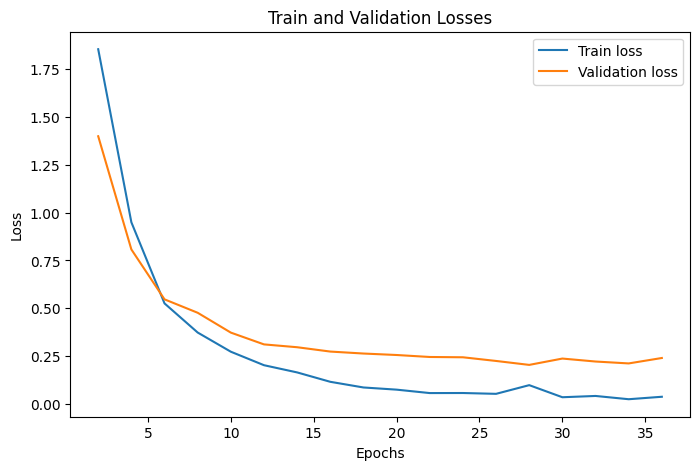

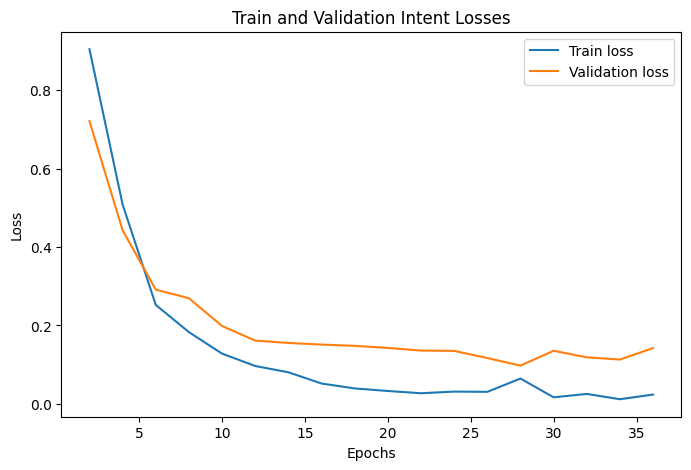

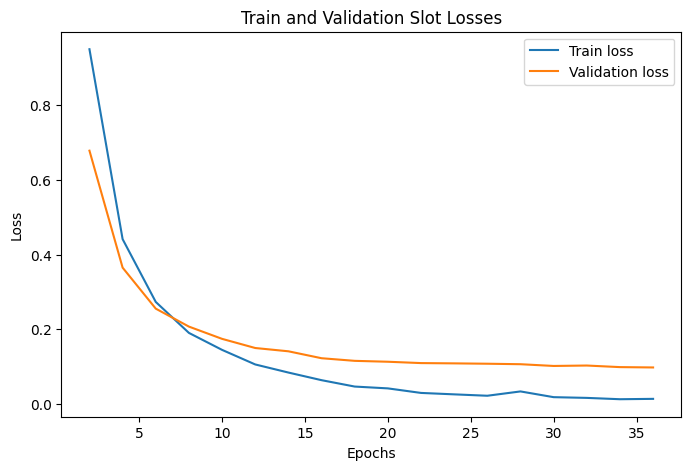

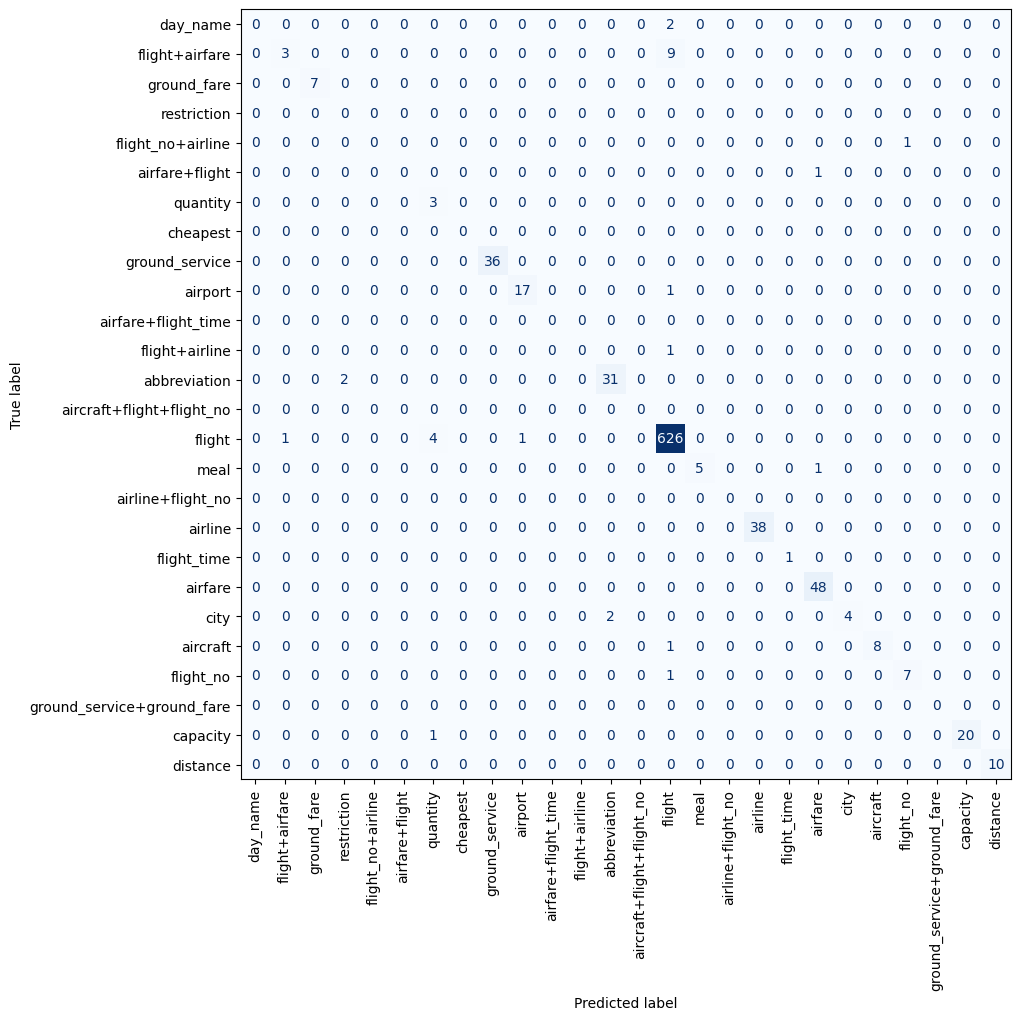

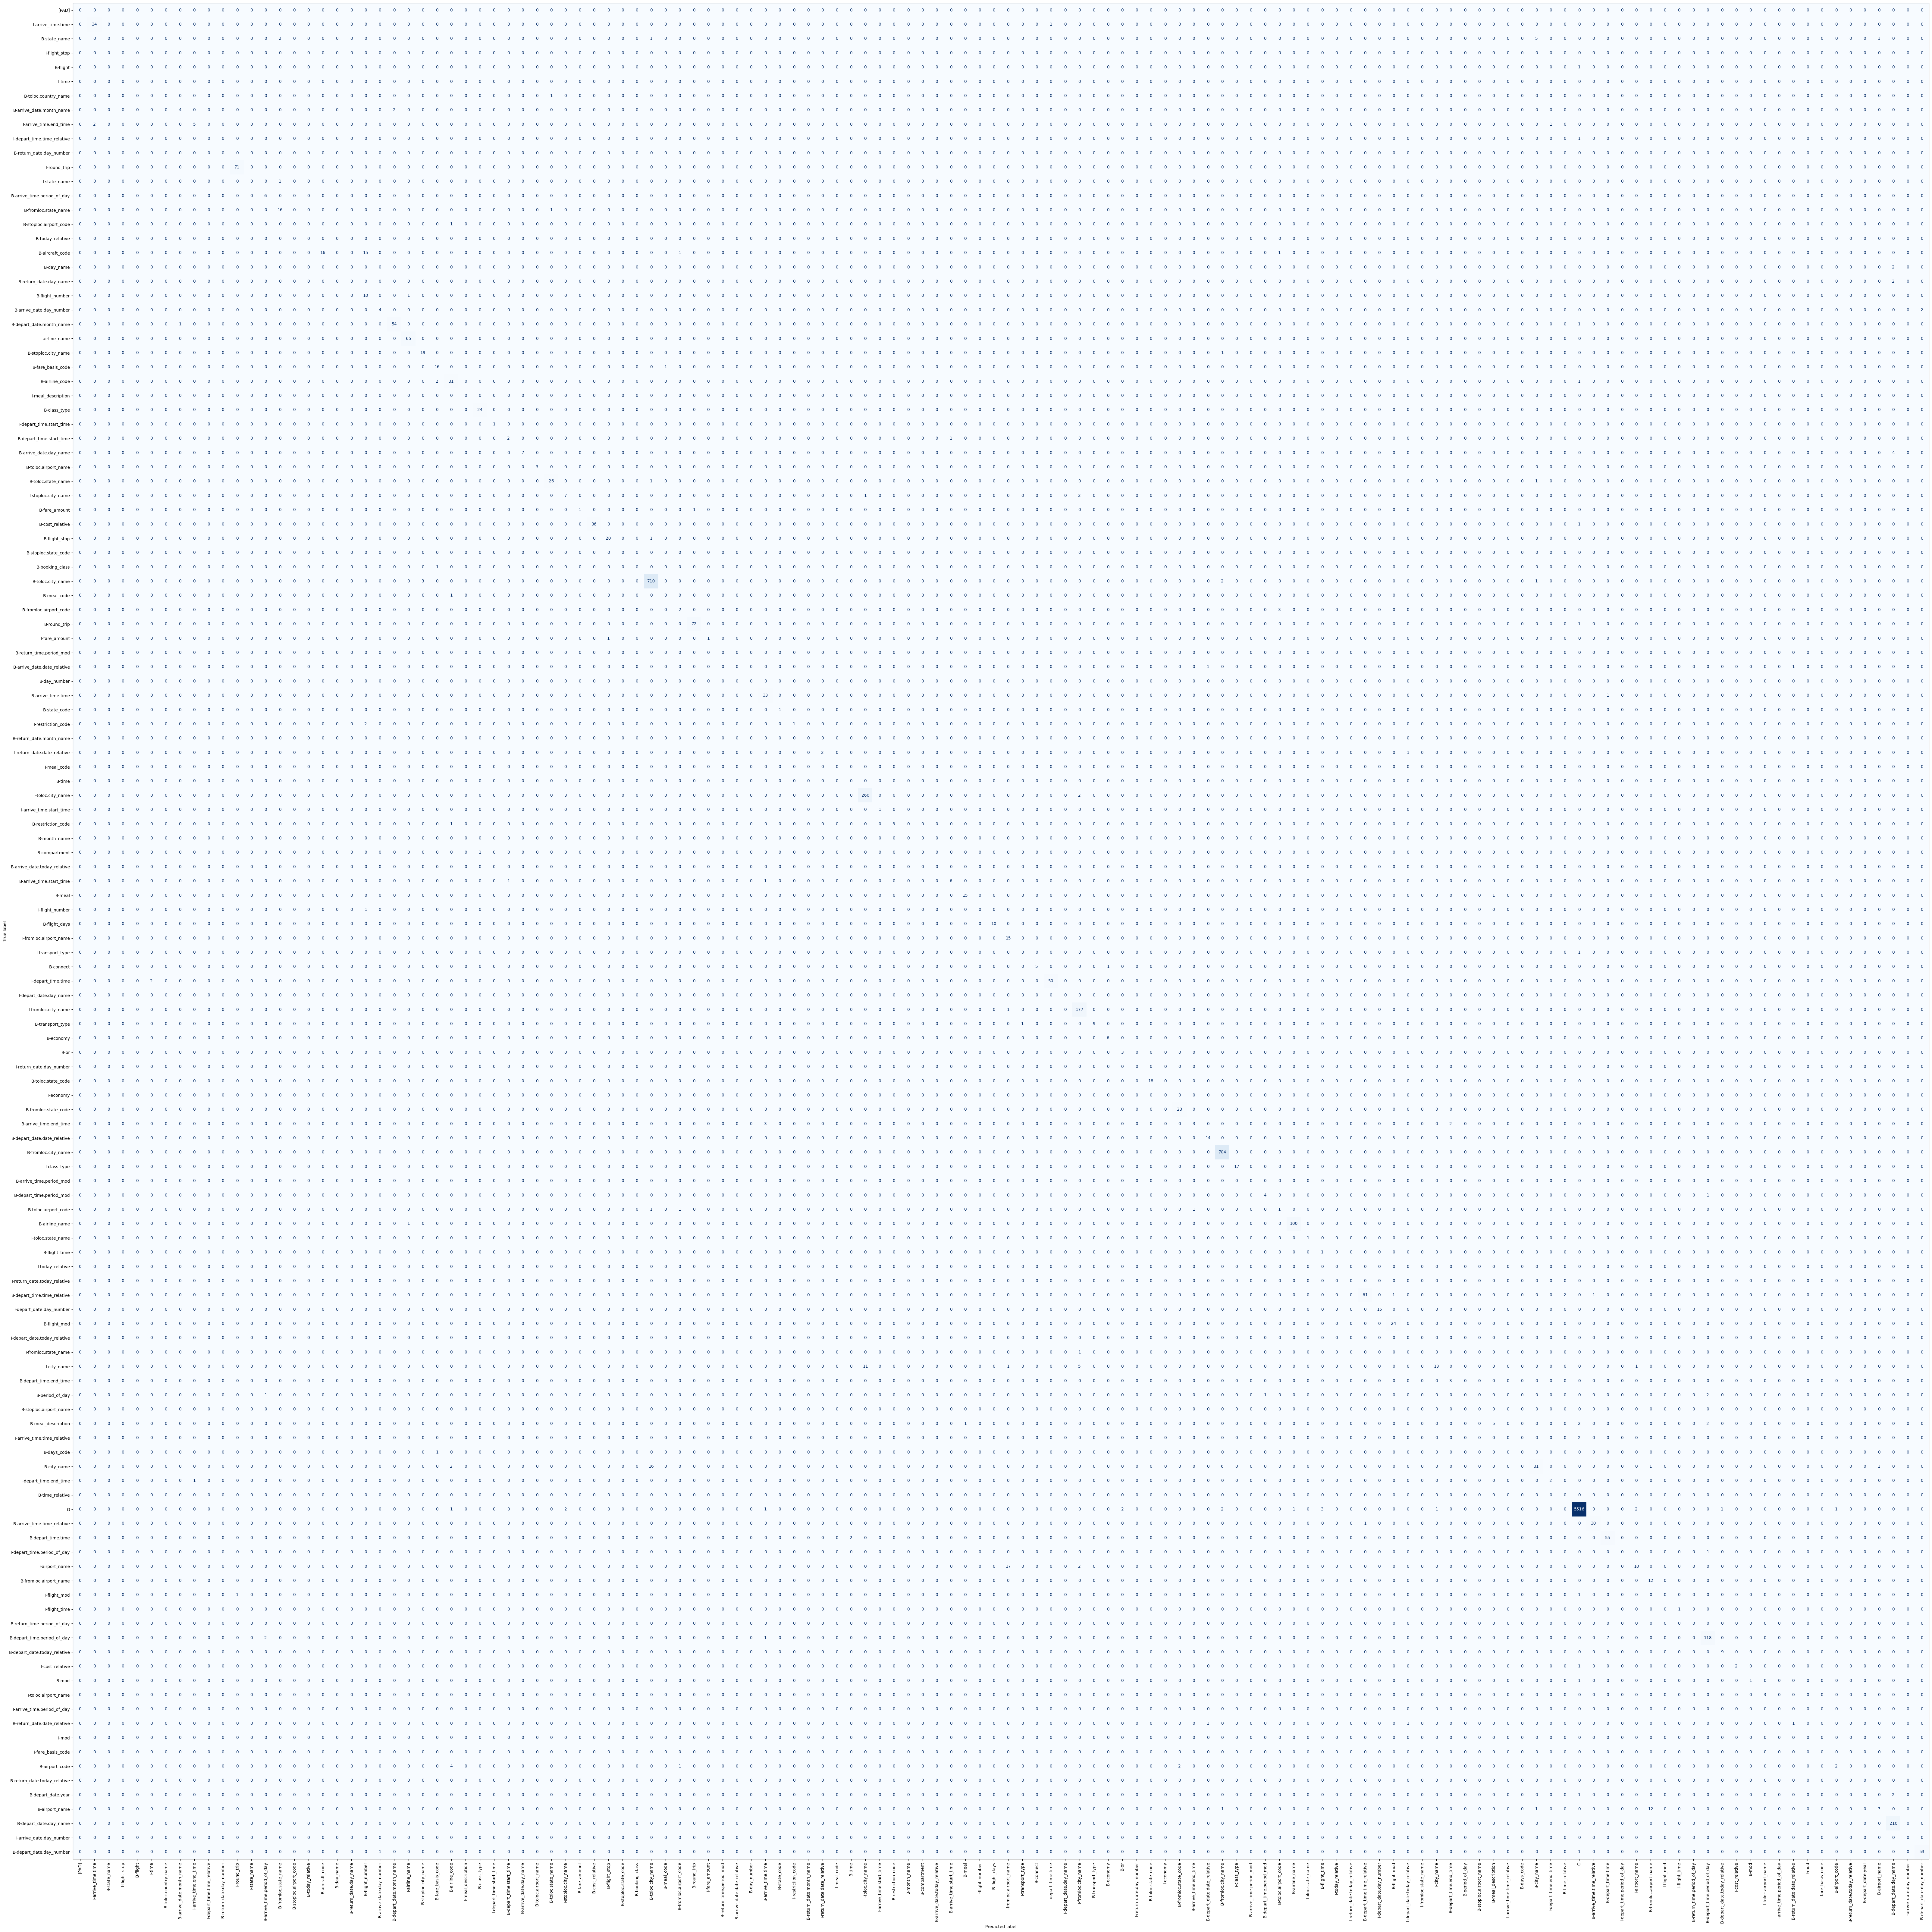

In [ ]:
show_training_results(params_atis_bert, lang)

### SNIPS

In [ ]:
snips = RawDatasetManager('SNIPS', snips_dir)

lang = BERTLang(snips, bert_tokenizer)

train_dataset = BERTCustomDataset(dataset=snips.train, lang=lang, tokenizer=bert_tokenizer)
valid_dataset = BERTCustomDataset(dataset=snips.valid, lang=lang, tokenizer=bert_tokenizer)
test_dataset = BERTCustomDataset(dataset=snips.test, lang=lang, tokenizer=bert_tokenizer)

model = BertBiNLU(
    n_intents=lang.n_intents,
    n_slots=lang.n_slots,
    max_sentence_length=lang.max_sentence_length
  ).to(device)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=256)
test_loader = DataLoader(test_dataset, batch_size=256)

params_snips_bert = bert_train_multiple_runs(
    model=model,
    n_runs=1,
    n_epochs=50,
    patience=5,
    lang=lang,
    train_loader=train_loader,
    valid_loader=valid_loader,
    test_loader=test_loader
)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Training  #1


 51%|█████     | 25/49 [38:41<37:08, 92.86s/it]


Intent accuracy: 0.984 +- 0.0
Slot F1: 0.95 +- 0.0



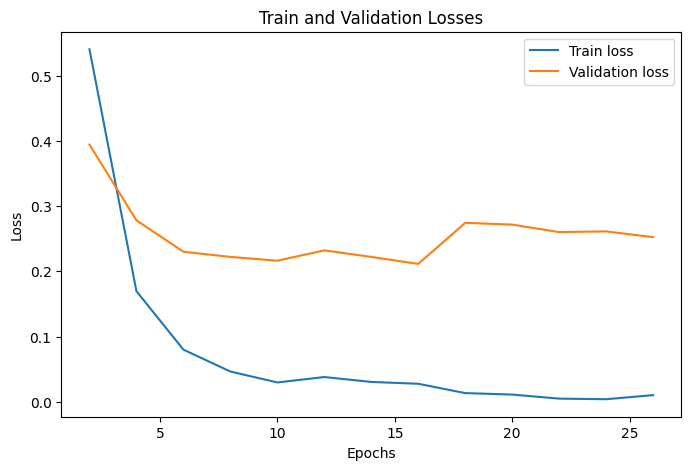

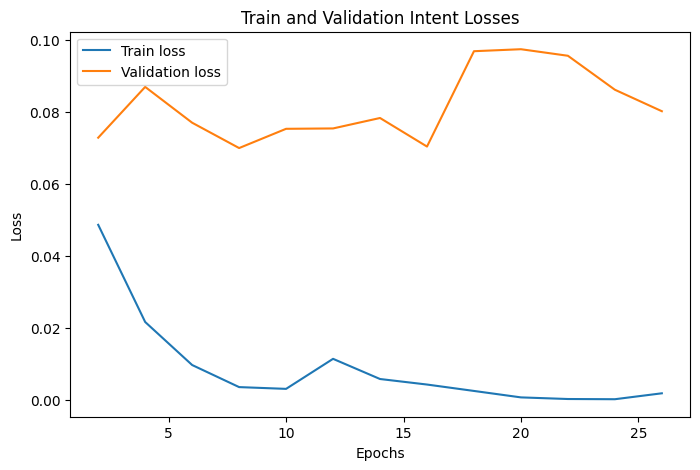

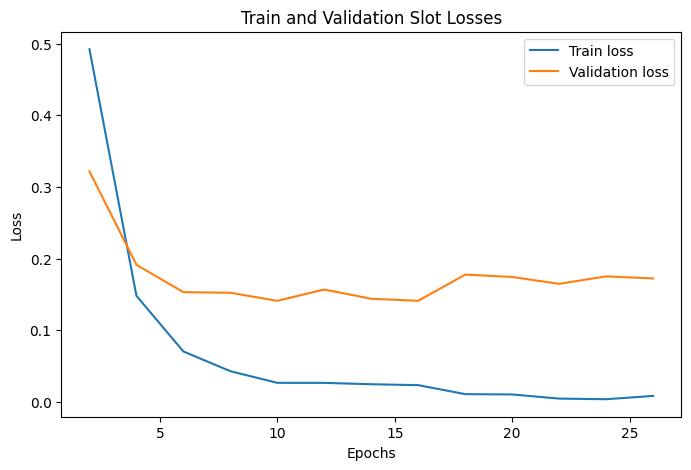

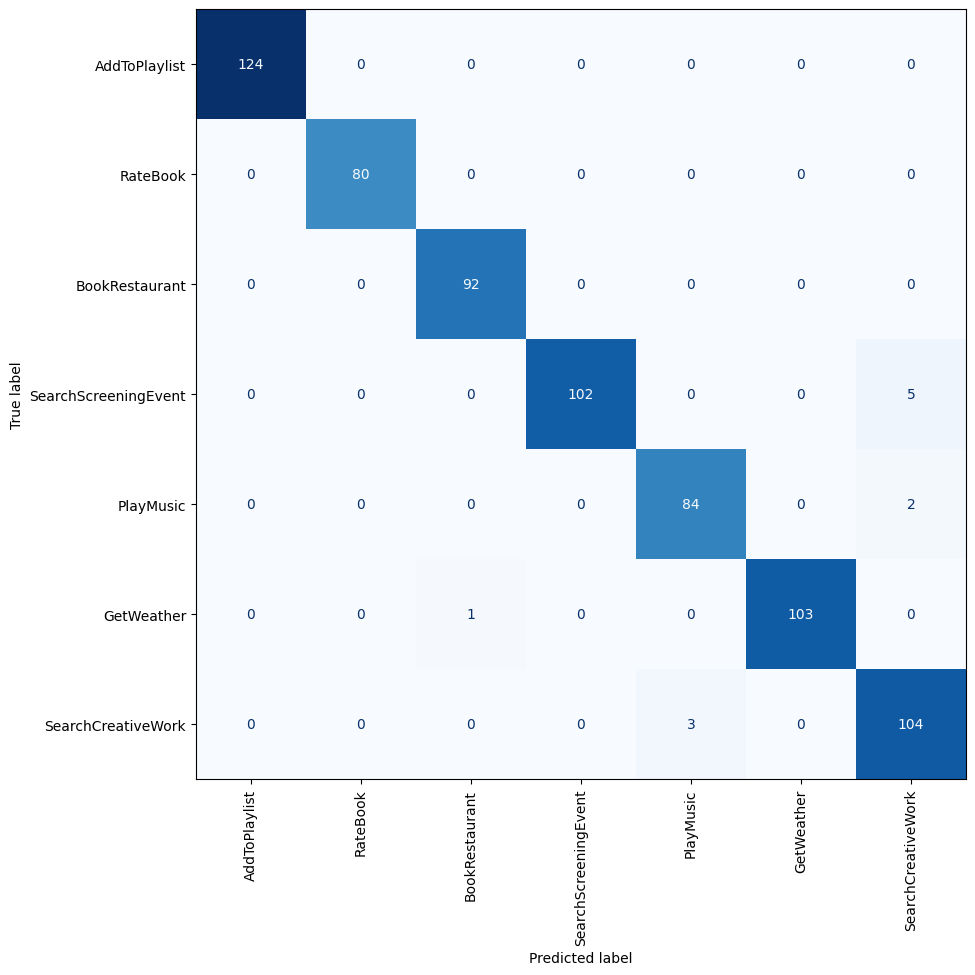

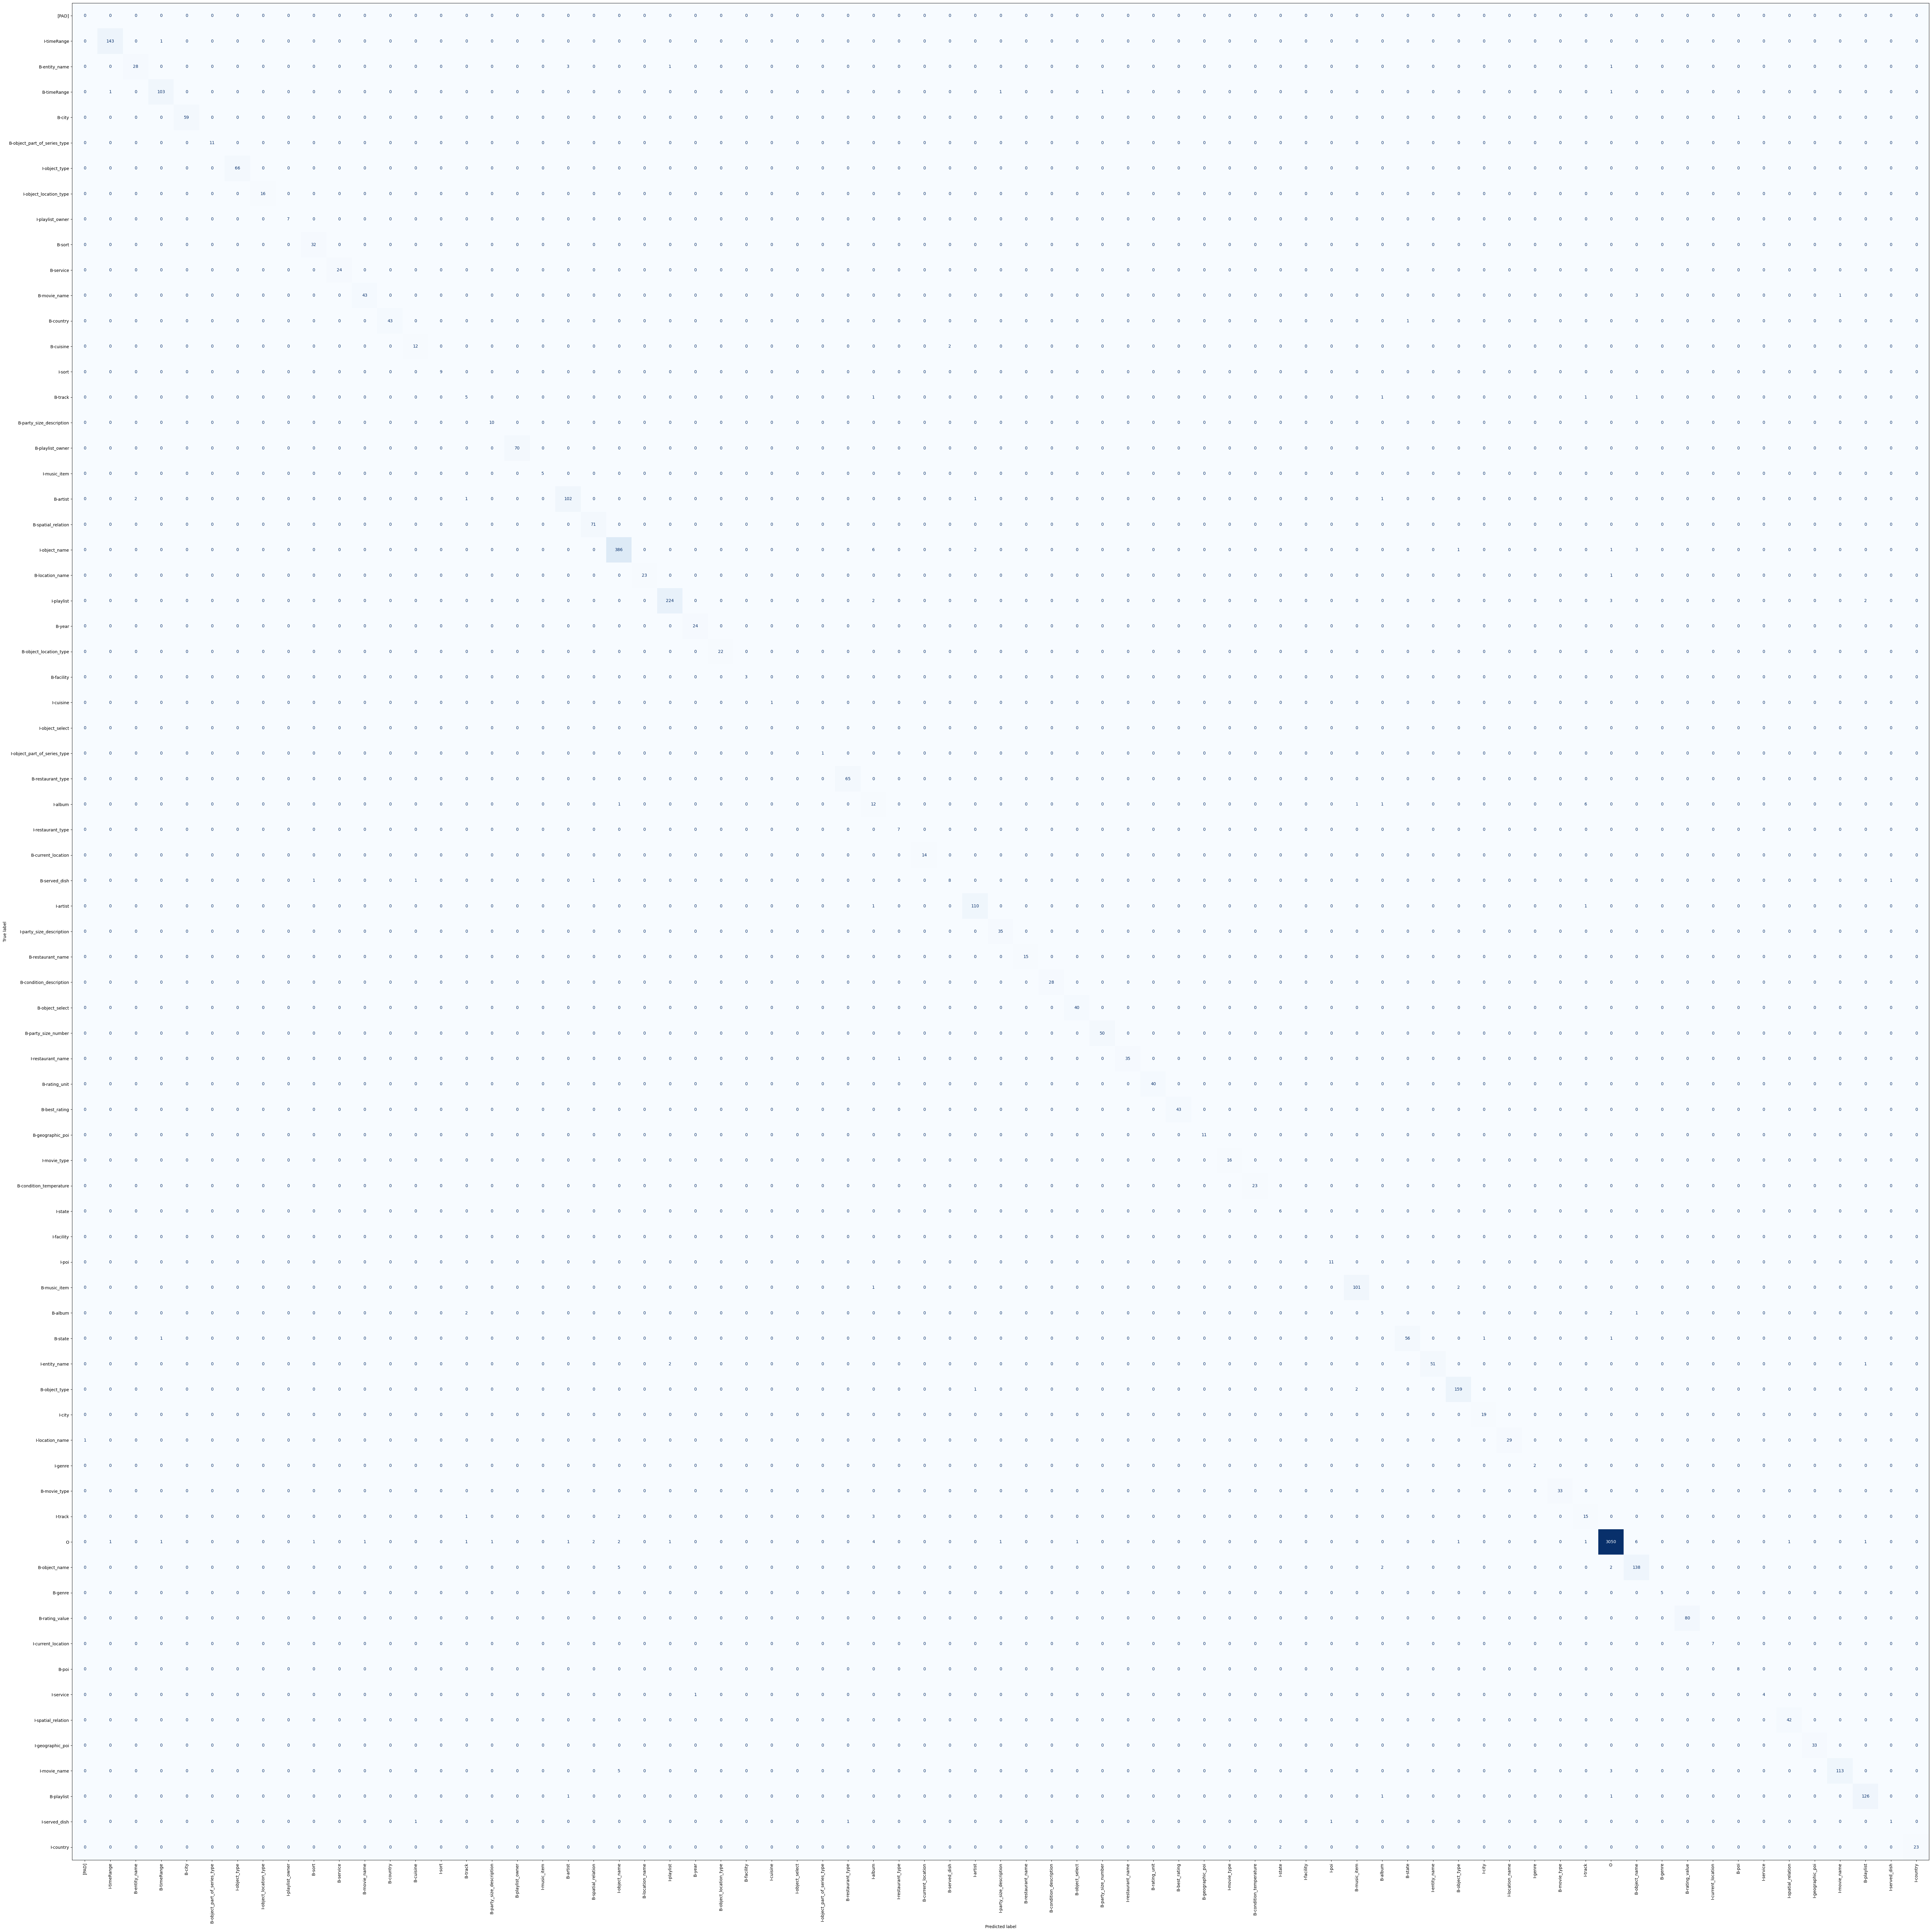

In [ ]:
show_training_results(params_snips_bert, lang)

# Bi-directional GRU + Bi-Directional NLU mechanism + CRF

## Language class to handle vocabulary
I use white space tokenizer, so there is no need to adapt things like with BERT based model.

In [ ]:
class MyLang():
  def __init__(self, raw_dataset_manager: RawDatasetManager):
    train = raw_dataset_manager.train
    validation = raw_dataset_manager.valid
    test = raw_dataset_manager.test
    all = raw_dataset_manager.get_all()

    words = [word for item in train for word in item.utterance.split()]
    intents = set([item.intent for item in all])
    slots = set([slot for item in all for slot in item.slots.split()])

    self.vocab_len = len(set(words))
    self.max_utt_len = max([len(item.utterance.split()) for item in all])

    self.word2id = self._w2id(words, unk=True)
    self.slot2id = self._lab2id(slots)
    self.intent2id = self._lab2id(intents, pad=False)
    self.id2word = {v:k for k, v in self.word2id.items()}
    self.id2slot = {v:k for k, v in self.slot2id.items()}
    self.id2intent = {v:k for k, v in self.intent2id.items()}

  def _w2id(self, elements, cutoff=None, unk=True):
    vocab = {pad_token: pad_id}
    if unk:
      vocab[unk_token] = len(vocab)
    count = Counter(elements)
    for k, v in count.items():
      vocab[k] = len(vocab)
    return vocab

  def _lab2id(self, elements, pad=True):
    vocab = {}
    if pad:
      vocab[pad_token] = pad_id
    for elem in elements:
      vocab[elem] = len(vocab)
    return vocab


## Custom Pytorch dataset

In [ ]:
class MyDataset(data.Dataset):
    def __init__(self, raw_dataset: RawDataset, lang: Lang):
      self.utterances = []
      self.intents = []
      self.slots = []

      self.max_utt_len = lang.max_utt_len

      for x in raw_dataset:
        self.utterances.append(x.utterance)
        self.slots.append(x.slots)
        self.intents.append(x.intent)

      self.utt_ids = self._mapping_seq(self.utterances, lang.word2id)
      self.slot_ids = self._mapping_seq(self.slots, lang.slot2id)
      self.intent_ids = self._mapping_lab(self.intents, lang.intent2id)

    def __len__(self):
      return len(self.utterances)

    def __getitem__(self, idx):
      utt = self.utt_ids[idx]
      slots = self.slot_ids[idx]
      intent = self.intent_ids[idx]

      # Add these for convenience
      original_utt = self.utterances[idx]
      original_slots = self.slots[idx]
      original_intent = self.intents[idx]
      original_utt_len = len(utt)

      # Pad
      utt = self._pad(utt, self.max_utt_len)
      slots = self._pad(slots, self.max_utt_len)

      sample = {
          'utterance': utt,
          'slots': slots,
          'intent': intent,
          'original_utt': original_utt,
          'original_slots': original_slots,
          'original_intent': original_intent,
          'original_utt_len': original_utt_len,
          }

      return sample

    def _mapping_lab(self, data, mapper):
      return [mapper[x] if x in mapper else mapper[unk_token] for x in data]

    def _mapping_seq(self, data, mapper): # Map sequences to number
      res = []
      for seq in data:
        tmp_seq = []
        for x in seq.split():
          if x in mapper:
            tmp_seq.append(mapper[x])
          else:
            tmp_seq.append(mapper[unk_token])
        res.append(tmp_seq)
      return res

    def _pad(self, seq, length):
      while(len(seq) < length):
        seq.append(pad_id)
      return seq



def my_collate_fn(data):

  # Sort data by seq lengths (needed for packed_pad_seq)
  data.sort(key=lambda x: x['original_utt_len'], reverse=True)

  # Get maximum length of sentence in the batch, in order to pad the slots only
  # to this length and not to the maximum sentence length of the whole dataset
  original_lengths = [x['original_utt_len'] for x in data]
  max_len_batch = max(original_lengths)

  return {
      'utterances': torch.LongTensor([x['utterance'] for x in data]).detach().to(device),
      'slots_list': torch.LongTensor([x['slots'][:max_len_batch] for x in data]).detach().to(device),
      'intents': torch.LongTensor([x['intent'] for x in data]).detach().to(device),
      'original_utts': [x['original_utt'] for x in data],
      'original_slots': [x['original_slots'] for x in data],
      'original_intents': [x['original_intent'] for x in data],
      'original_lengths': torch.LongTensor(original_lengths).detach().to(device),
  }

## Model architecture

In [ ]:
!pip install pytorch-crf

In [ ]:
from torchcrf import CRF


class LinearWithSoftmax(torch.nn.Module):
    def __init__(self, in_features, out_features):
      super(LinearWithSoftmax, self).__init__()
      self.linear = torch.nn.Linear(in_features, out_features)
      self.softmax = torch.nn.Softmax(-1)

    def forward(self, input):
      return self.softmax(self.linear(input))


class MyIntent2Slot(torch.nn.Module):
  def __init__(self, input_size, out_intent, out_slot):
    super(MyIntent2Slot, self).__init__()

    # Classifier from last_hidden to intent
    self.intent_classifier = LinearWithSoftmax(input_size, out_intent)

    # Classifier to predict the slot of each token augmented with intent information
    self.slot_classifier = torch.nn.Linear(input_size + out_intent, out_slot)

  def forward(self, last_hidden, utt_hid):
    # last_hidden shape: (batch_size, input_size)
    # utt_hid shape: (batch_size, n_tokens, input_size)
    n_tokens = utt_hid.size(1)

    # Get most probable intent given last_hidden. Shape: (batch_size, out_slot)
    p_intent = self.intent_classifier(last_hidden)

    p_intent = p_intent.unsqueeze(1) # Shape: (batch_size, 1, out_intent)
    p_intent = p_intent.repeat(1, n_tokens, 1) # Repeat for each token, shape: (batch_size, n_tokens, out_intent)

    # Extend each token hidden rep with p_intent, shape: (batch_size, n_tokens, input_size + out_intent)
    tokens_hid_cat_p_intent = torch.cat((utt_hid, p_intent), 2)

    # Predict slot for each token. Shape: (batch_size, n_tokens, out_slot)
    result = self.slot_classifier(tokens_hid_cat_p_intent)

    return result


class MySlot2Intent(torch.nn.Module):
  def __init__(self, input_size, out_intent, out_slot, n_tokens):
    super(MySlot2Intent, self).__init__()

    # Classifier that predicts the slot of each token
    self.slot_classifier = LinearWithSoftmax(input_size, out_slot)

    # A final classifier that takes last_hidden, augumented with all the slots information, to predict the intent
    self.intent_classifier = torch.nn.Linear(input_size + (out_slot * n_tokens), out_intent)

  def forward(self, last_hidden, utt_hid):
    # last_hidden shape: (batch_size, input_size)
    # utt_hid shape: (batch_size, n_tokens, input_size)
    n_tokens = utt_hid.size(1)

    # Predict slots. Shape: (batch_size, n_tokens, out_slot)
    result = self.slot_classifier(utt_hid)

    # Now flatten it to shape (batch_size, n_tokens*n_slots)
    result = torch.flatten(result, 1)

    # Now cat all of that on last_hidden
    result = torch.cat((last_hidden, result), 1)

    # Classify for intent
    result = self.intent_classifier(result)

    return result

class MyModel(torch.nn.Module):
  def __init__(self, vocab_len, emb_size, hid_size, n_gru_layers, n_tokens, out_slot, out_intent):
    super(MyModel, self).__init__()

    self.n_tokens = n_tokens

    # Embedding layer
    self.embedding = nn.Embedding(vocab_len, emb_size, padding_idx=pad_id)

    # GRU layer(s) for encoding into hidden representation
    self.gru = nn.GRU(emb_size, hid_size, n_gru_layers, bidirectional=True, batch_first=True)

    # Intent and slots classifiers
    self.intent2slot = MyIntent2Slot(hid_size*2, out_intent, out_slot)
    self.slot2intent = MySlot2Intent(hid_size*2, out_intent, out_slot, n_tokens)

    # CRF
    self.crf = CRF(out_slot, batch_first=True)

  def forward(self, utterances, seq_lengths):
    # Get embedding
    embeddings = self.embedding(utterances)

    # Avoid computation over pad tokens reducing the computational cost
    packed_input = pack_padded_sequence(embeddings, seq_lengths.cpu(), batch_first=True)
    packed_output, last_hidden = self.gru(packed_input)
    utt_encoded, utt_lengths = pad_packed_sequence(packed_output, batch_first=True)

    # Re-pad to the maximum sentence length in the whole dataset (add zeros)
    # This is needed for slot2intent classifier
    utt_encoded_padded = torch.zeros(utt_encoded.size(0), self.n_tokens, utt_encoded.size(2)).to(device)
    for id_utt, utt in enumerate(utt_encoded):
      utt_len = int(utt_lengths[id_utt])
      utt_encoded_padded[id_utt,:utt_len] = utt_encoded[id_utt,:utt_len]

    # Get the last hidden state, taking into account bidirectional=True
    last_hidden_forward, last_hidden_backward = last_hidden[0], last_hidden[1]
    last_hidden = torch.cat((last_hidden_forward, last_hidden_backward), 1) # Concatenate both states. Shape: (batch_size, 2*hid_size)

    # Compute slot logits
    slots = self.intent2slot(last_hidden, utt_encoded)
    # Compute intent logits
    intent = self.slot2intent(last_hidden, utt_encoded_padded)

    return slots, intent

## Training and evaluation procedures
In this section, I define the main training and evaluation loops, specific to this model.

In [ ]:
def my_train_loop(model: MyModel, dataloader: DataLoader, optimizer: Optimizer, criterion_slots, criterion_intents):

  # Set model in training mode
  model.train()

  # Keep track of losses
  loss_dict = {'total': [], 'intent': [], 'slot': []}

  for batch in dataloader:

    # Zeroing the gradient
    optimizer.zero_grad()

    # Forward pass
    predicted_slots, predicted_intents = model(batch['utterances'], batch['original_lengths'])

    # Compute loss
    loss_slot = -1 * model.crf(predicted_slots, batch['slots_list'], reduction='token_mean')
    loss_intent = criterion_intents(predicted_intents, batch['intents'])
    loss = 0.4 * loss_intent + 0.6 * loss_slot

    loss_dict['total'].append(loss.item())
    loss_dict['intent'].append(loss_intent.item())
    loss_dict['slot'].append(loss_slot.item())

    # Compute gradient and backpropagate it, updating weights
    loss.backward()
    optimizer.step()

  return loss_dict


def my_eval_loop(model: MyModel, dataloader: DataLoader, criterion_slots, criterion_intents, lang: MyLang):

  # Set model in evaluation mode
  model.eval()

  # Keep track of losses
  loss_dict = {'total': [], 'intent': [], 'slot': []}

  ref_intents = []
  hyp_intents = []
  ref_slots = []
  hyp_slots = []

  with torch.no_grad(): # Avoid creation of computational graph
    for batch in dataloader:

      # Forward pass
      predicted_slots, predicted_intents = model(batch['utterances'], batch['original_lengths'])

      # Compute loss
      loss_slot = -1 * model.crf(predicted_slots, batch['slots_list'], reduction='token_mean')
      loss_intent = criterion_intents(predicted_intents, batch['intents'])
      loss = 0.4 * loss_intent + 0.6 * loss_slot

      loss_dict['total'].append(loss.item())
      loss_dict['intent'].append(loss_intent.item())
      loss_dict['slot'].append(loss_slot.item())

      # Intent inference
      decoded_pred_intents = [lang.id2intent[x] for x in torch.argmax(predicted_intents, dim=1).tolist()]
      hyp_intents.extend(decoded_pred_intents)

      decoded_target_intents = batch['original_intents']
      ref_intents.extend(decoded_target_intents)

      # Slot inference
      predicted_slots_decoded = torch.LongTensor(model.crf.decode(predicted_slots)).to(device)
      for id_seq, seq in enumerate(predicted_slots_decoded):
        utt = batch['original_utts'][id_seq].split()
        length = len(utt)

        gt_slots = batch['original_slots'][id_seq].split()

        ref_slots.append([(utt[id_el], elem) for id_el, elem in enumerate(gt_slots)])

        to_decode = seq[:length].tolist()
        tmp_seq = []
        for id_el, elem in enumerate(to_decode):
            tmp_seq.append((utt[id_el], lang.id2slot[elem]))
        hyp_slots.append(tmp_seq)

  results = evaluate(ref_slots, hyp_slots)
  report_intent = classification_report(ref_intents, hyp_intents, zero_division=False, output_dict=True)

  # Confusion matrices
  conf_matrix_slot = confusion_matrix([token[1] for sent in ref_slots for token in sent], [token[1] for sent in hyp_slots for token in sent], labels=list(lang.slot2id.keys()))
  conf_matrix_intent = confusion_matrix(ref_intents, hyp_intents, labels=list(lang.intent2id.keys()))
  conf_matrices = {'intent': conf_matrix_intent, 'slot': conf_matrix_slot}

  return results, report_intent, loss_dict, conf_matrices

Having defined this loops, I put it all together in the following functions.

In [ ]:
def my_train(model: MyModel, n_epochs: int, eval_rate: int, patience: int, lang: MyLang, train_loader: DataLoader, valid_loader: DataLoader, optimizer: Optimizer, criterion_slots, criterion_intents):
  loss_dict_train = {'total': [], 'intent': [], 'slot': []}
  loss_dict_valid = {'total': [], 'intent': [], 'slot': []}
  sampled_epochs = []
  best_f1 = 0
  for x in tqdm(range(1,n_epochs)):

    loss_dict = my_train_loop(model, train_loader, optimizer, criterion_slots, criterion_intents)

    if x % eval_rate == 0:
      sampled_epochs.append(x)

      loss_dict_train['total'].append(np.asarray(loss_dict['total']).mean())
      loss_dict_train['intent'].append(np.asarray(loss_dict['intent']).mean())
      loss_dict_train['slot'].append(np.asarray(loss_dict['slot']).mean())

      results_valid, intent_res, loss_dict, _ = my_eval_loop(model, valid_loader, criterion_slots, criterion_intents, lang)

      loss_dict_valid['total'].append(np.asarray(loss_dict['total']).mean())
      loss_dict_valid['intent'].append(np.asarray(loss_dict['intent']).mean())
      loss_dict_valid['slot'].append(np.asarray(loss_dict['slot']).mean())

      f1 = results_valid['total']['f']

      if f1 > best_f1:
          best_f1 = f1
      else:
          patience -= 1
      if patience <= 0: # Early stoping with patience
          break

  return loss_dict_train, loss_dict_valid, sampled_epochs

def my_test(model: MyModel, lang: Lang, test_loader: DataLoader, criterion_slots, criterion_intents):
  results_test, intent_test, _, conf_matrices = my_eval_loop(model, test_loader, criterion_slots, criterion_intents, lang)

  return intent_test['accuracy'], results_test['total']['f'], conf_matrices

## Training and evaluating the model
Now I can finally run the training and evaluation procedures, setting everything up.

In [ ]:
emb_size = 400
hid_size = 600
n_gru_layers = 2

lr = 0.0001
optimizer = 'adam'
criterion_slots = nn.CrossEntropyLoss(ignore_index=pad_id)
criterion_intents = nn.CrossEntropyLoss()

train_batch_size = 128
valid_batch_size = 2048
test_batch_size = 2048
n_runs=5
n_epochs=100
patience=5
eval_rate=5

### ATIS

In [ ]:
atis = RawDatasetManager('ATIS', atis_dir)

lang = MyLang(atis)

train_dataset = MyDataset(atis.train, lang)
valid_dataset = MyDataset(atis.valid, lang)
test_dataset = MyDataset(atis.test, lang)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, collate_fn=my_collate_fn)

params = []

for run_id in range(n_runs):
  print(f'Training  #{run_id+1}')

  my_model = MyModel(
    vocab_len=len(lang.word2id),
    emb_size=emb_size,
    hid_size=hid_size,
    n_gru_layers=n_gru_layers,
    n_tokens=lang.max_utt_len,
    out_slot=len(lang.slot2id),
    out_intent=len(lang.intent2id)
  ).to(device)
  my_model.apply(init_weights)

  optimizer = optim.Adam(my_model.parameters(), lr=lr)

  loss_dict_train, loss_dict_valid, sampled_epochs = my_train(my_model, n_epochs, eval_rate, patience, lang, train_loader, valid_loader, optimizer, criterion_slots, criterion_intents)

  intent_score, slot_score, conf_matrices = my_test(my_model, lang, test_loader, criterion_slots, criterion_intents)

  run_params = {}
  run_params['loss_dict_train'] = loss_dict_train
  run_params['loss_dict_valid'] = loss_dict_valid
  run_params['sampled_epochs'] = sampled_epochs
  run_params['intent_score'] = intent_score
  run_params['slot_score'] = slot_score
  run_params['conf_matrix_slot'] = conf_matrices['slot']
  run_params['conf_matrix_intent'] = conf_matrices['intent']
  params.append(run_params)

  print()

File data/ATIS/valid.json not found
Performing train/validation split... Done

Training  #1


100%|██████████| 99/99 [20:23<00:00, 12.36s/it]



Training  #2


100%|██████████| 99/99 [20:26<00:00, 12.39s/it]



Training  #3


100%|██████████| 99/99 [20:31<00:00, 12.44s/it]



Training  #4


100%|██████████| 99/99 [20:28<00:00, 12.41s/it]



Training  #5


 90%|████████▉ | 89/99 [18:40<02:05, 12.59s/it]


Intent accuracy: 0.953 +- 0.006
Slot F1: 0.941 +- 0.009



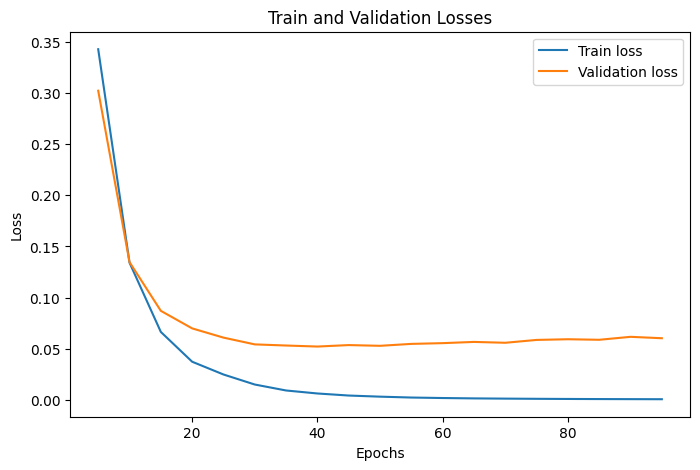

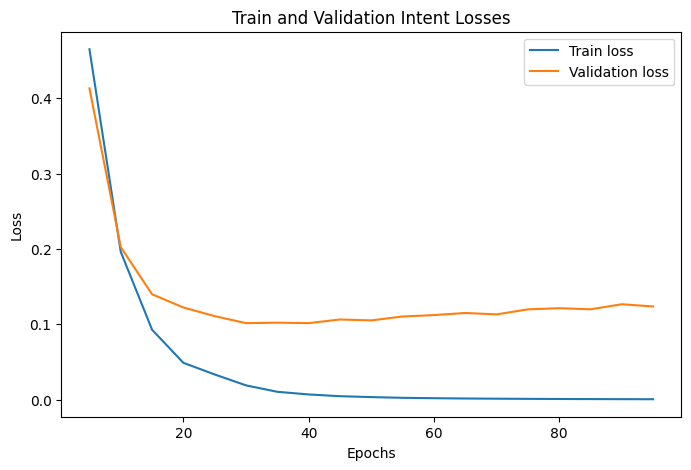

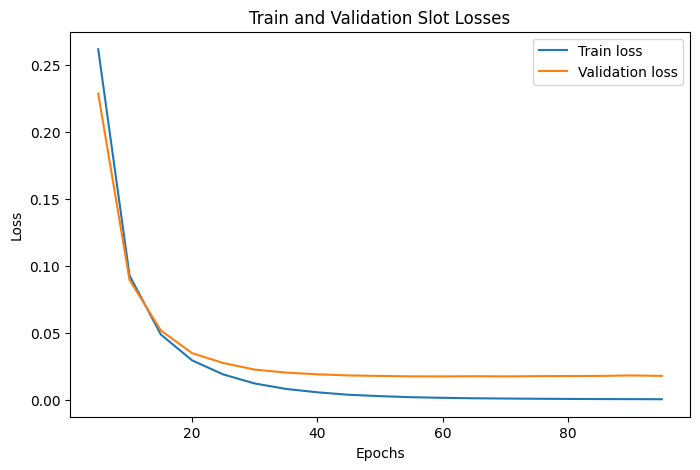

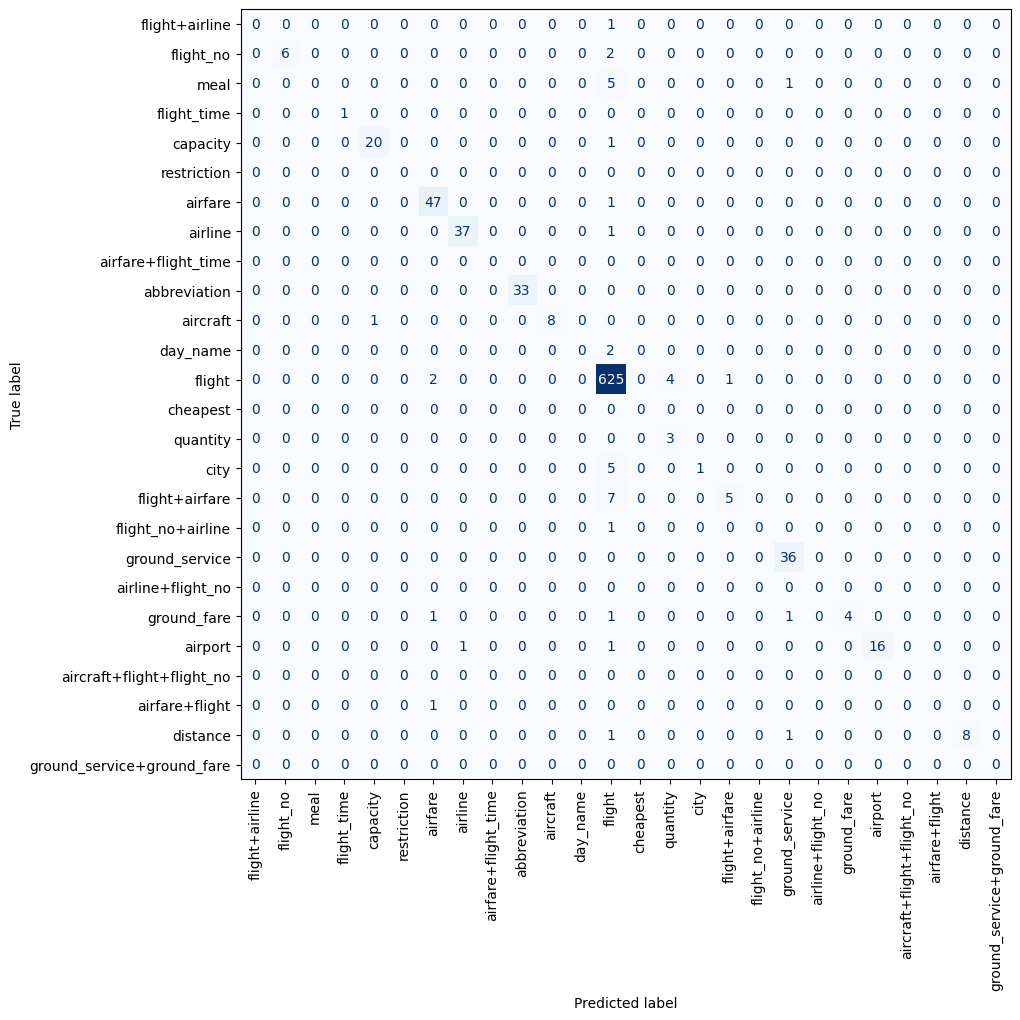

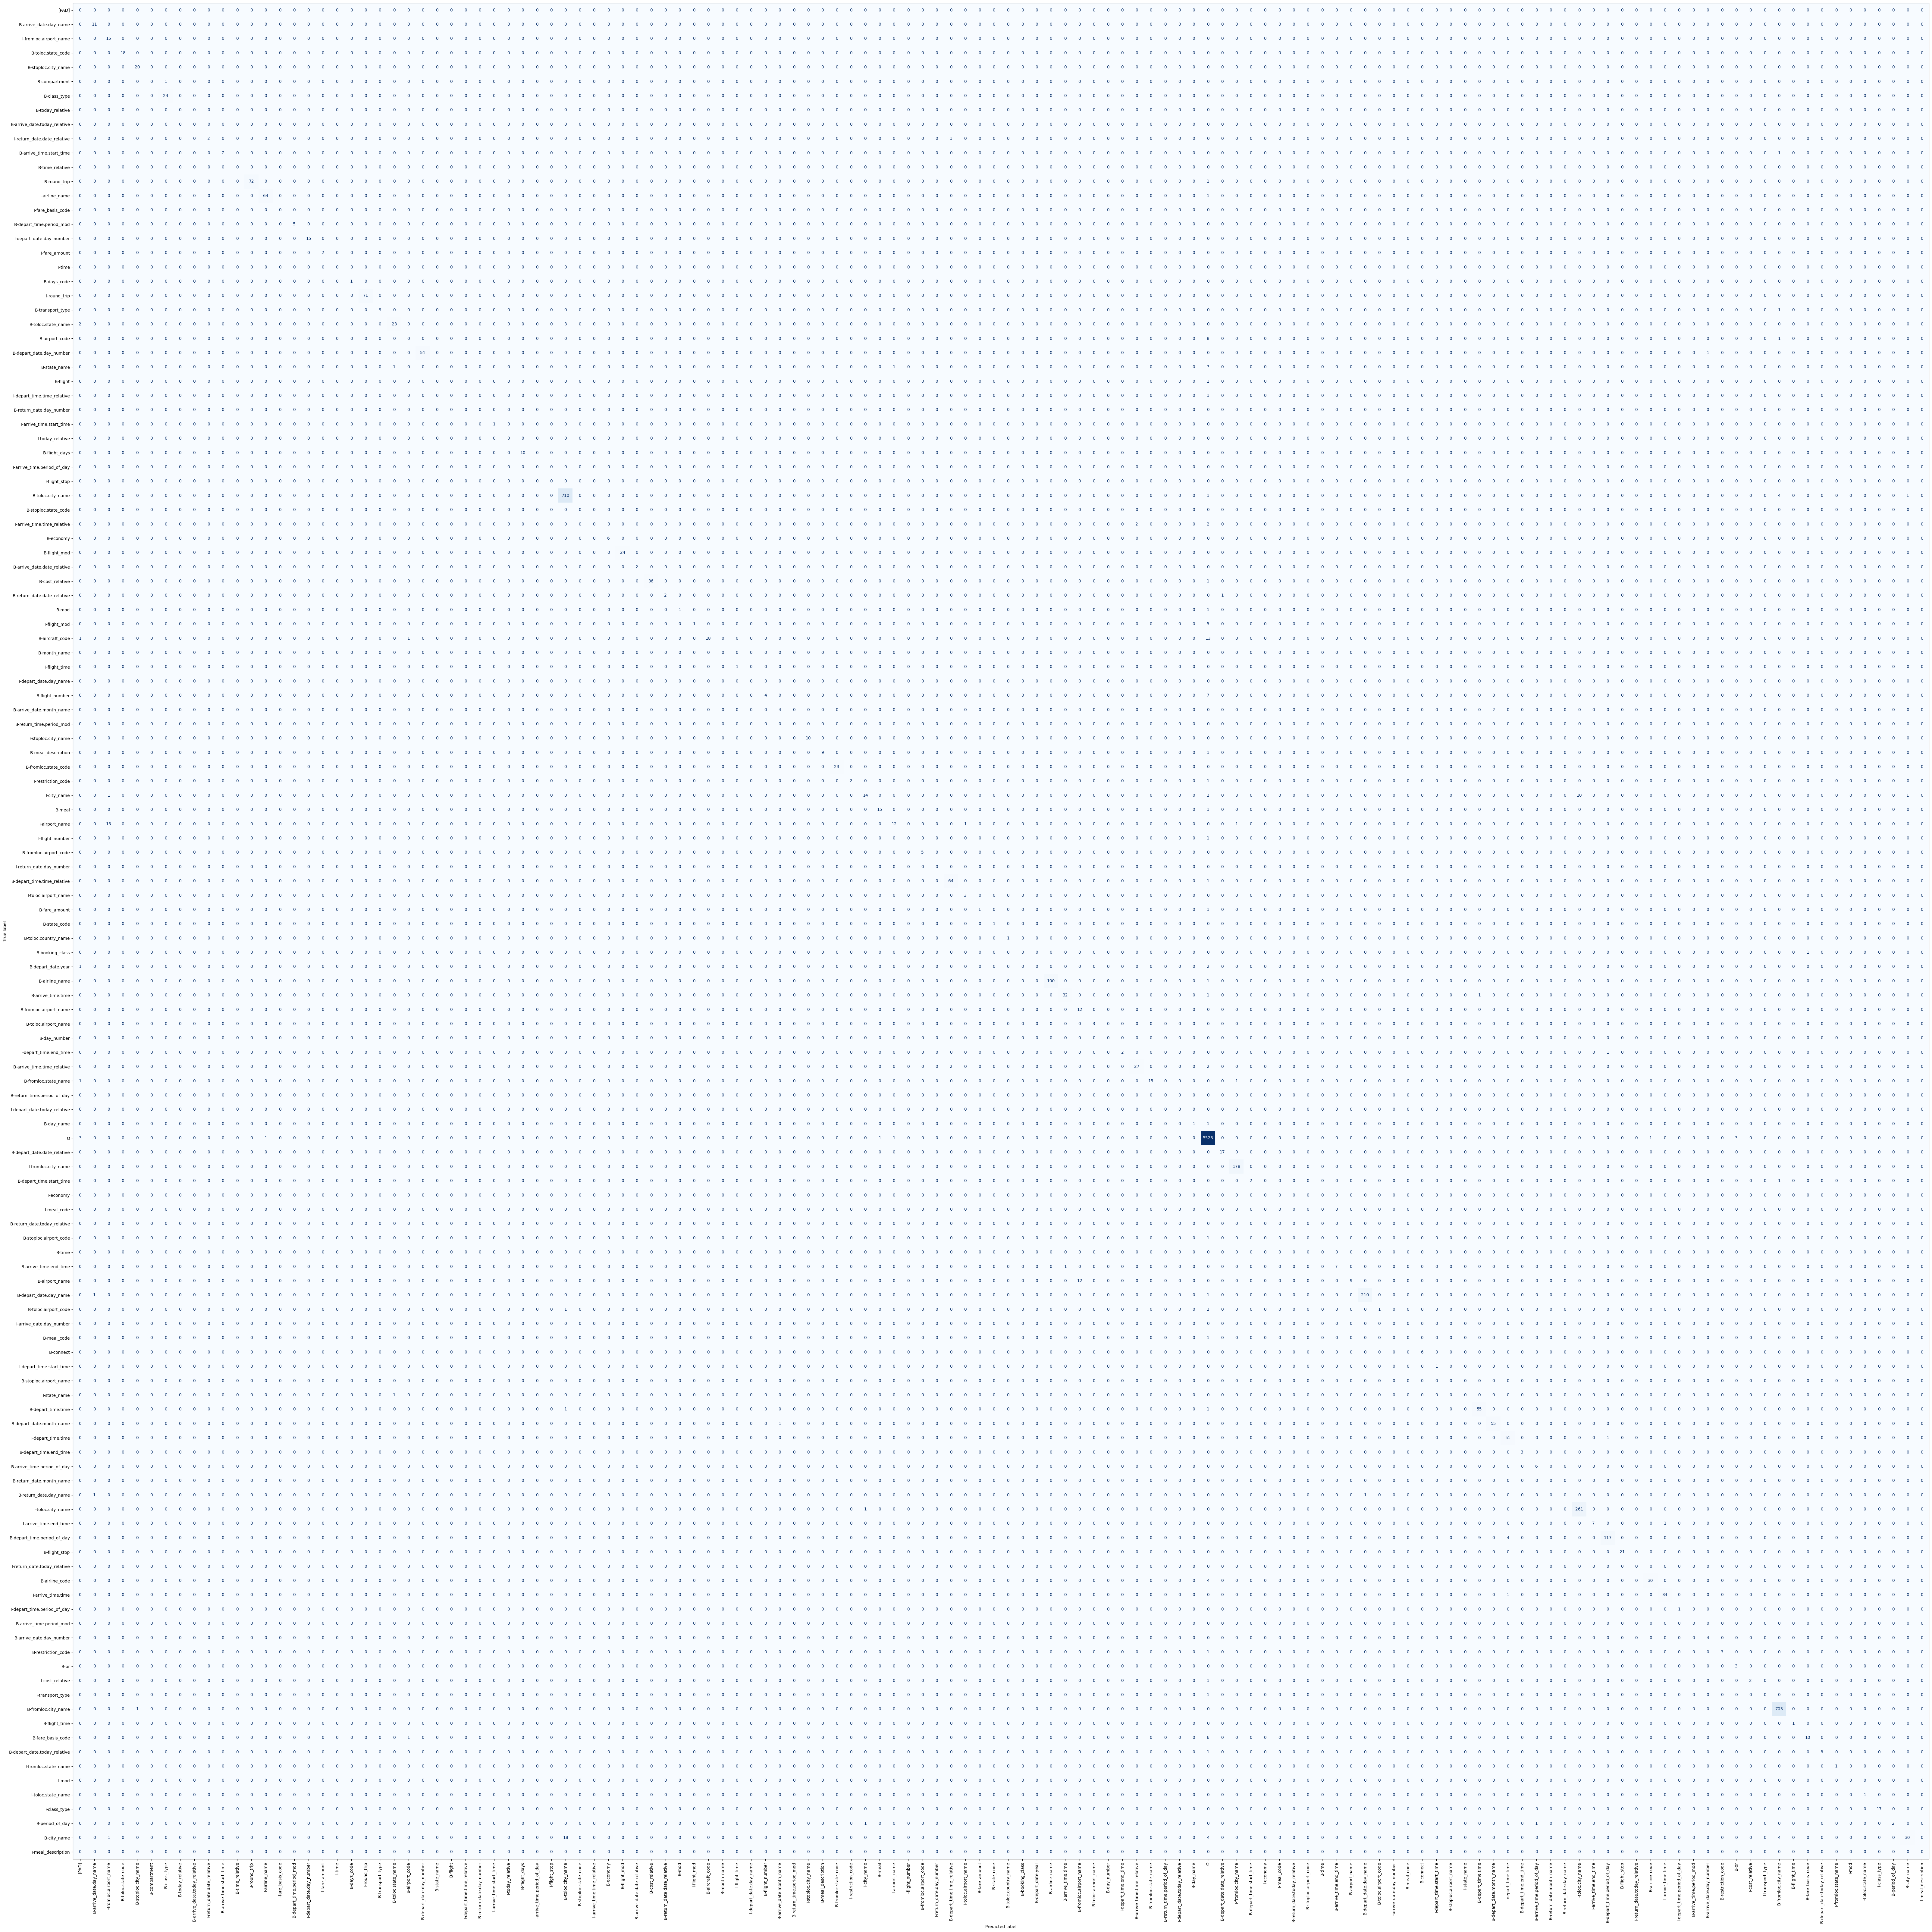

In [ ]:
show_training_results(params, lang)

### SNIPS

In [ ]:
snips = RawDatasetManager('SNIPS', snips_dir)

lang = MyLang(snips)

train_dataset = MyDataset(snips.train, lang)
valid_dataset = MyDataset(snips.valid, lang)
test_dataset = MyDataset(snips.test, lang)

train_loader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True, collate_fn=my_collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=valid_batch_size, collate_fn=my_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=test_batch_size, collate_fn=my_collate_fn)

params = []

for run_id in range(n_runs):
  print(f'Training  #{run_id+1}')

  my_model = MyModel(
    vocab_len=len(lang.word2id),
    emb_size=emb_size,
    hid_size=hid_size,
    n_gru_layers=n_gru_layers,
    n_tokens=lang.max_utt_len,
    out_slot=len(lang.slot2id),
    out_intent=len(lang.intent2id)
  ).to(device)
  my_model.apply(init_weights)

  optimizer = optim.Adam(my_model.parameters(), lr=lr)

  loss_dict_train, loss_dict_valid, sampled_epochs = my_train(my_model, n_epochs, eval_rate, patience, lang, train_loader, valid_loader, optimizer, criterion_slots, criterion_intents)

  intent_score, slot_score, conf_matrices = my_test(my_model, lang, test_loader, criterion_slots, criterion_intents)

  run_params = {}
  run_params['loss_dict_train'] = loss_dict_train
  run_params['loss_dict_valid'] = loss_dict_valid
  run_params['sampled_epochs'] = sampled_epochs
  run_params['intent_score'] = intent_score
  run_params['slot_score'] = slot_score
  run_params['conf_matrix_slot'] = conf_matrices['slot']
  run_params['conf_matrix_intent'] = conf_matrices['intent']
  params.append(run_params)

  print()

Training  #1


  0%|          | 0/99 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torchcrf/__init__.py:249: UserWarning: where received a uint8 condition tensor. This behavior is deprecated and will be removed in a future version of PyTorch. Use a boolean condition instead. (Triggered internally at ../aten/src/ATen/native/TensorCompare.cpp:519.)
  score = torch.where(mask[i].unsqueeze(1), next_score, score)
100%|██████████| 99/99 [43:25<00:00, 26.32s/it]



Training  #2


 75%|███████▍  | 74/99 [33:10<11:12, 26.90s/it]



Training  #3


 65%|██████▍   | 64/99 [28:33<15:37, 26.77s/it]


Intent accuracy: 0.963 +- 0.009
Slot F1: 0.874 +- 0.029



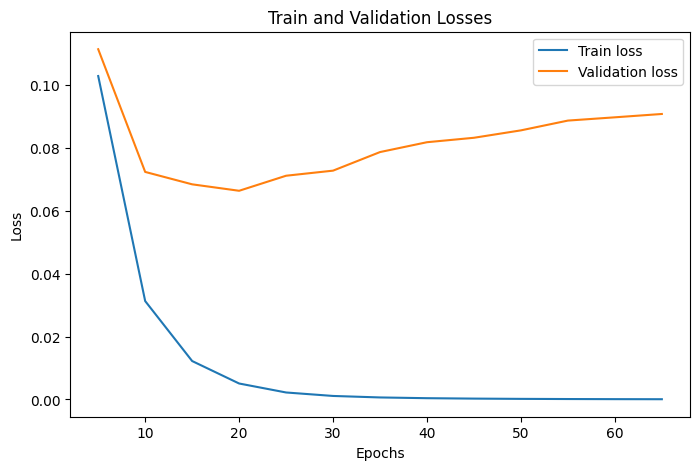

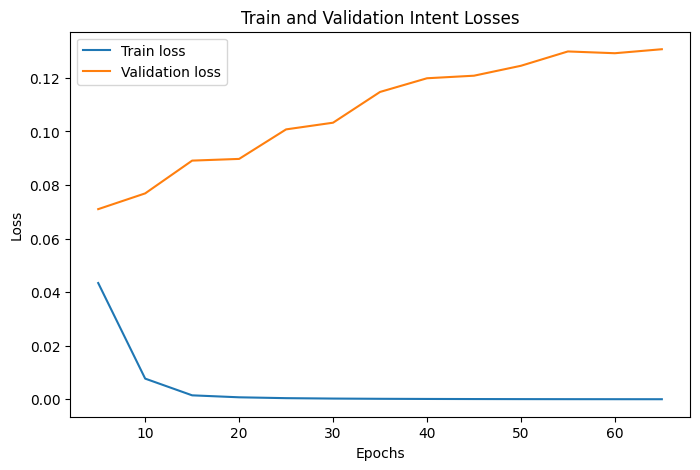

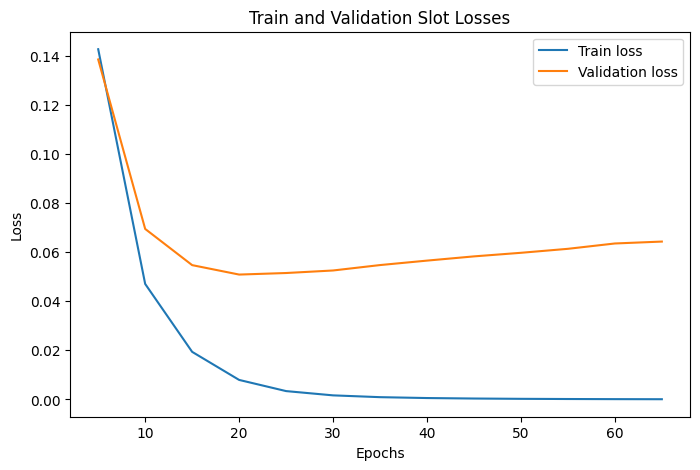

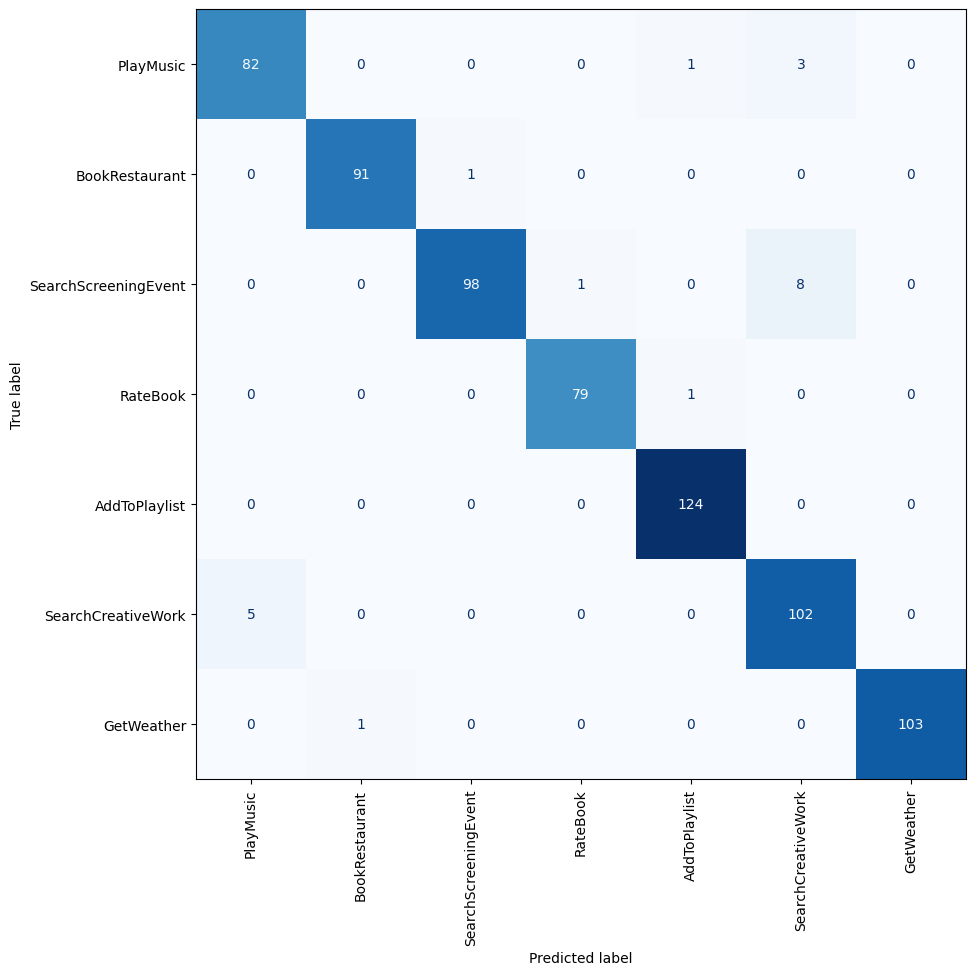

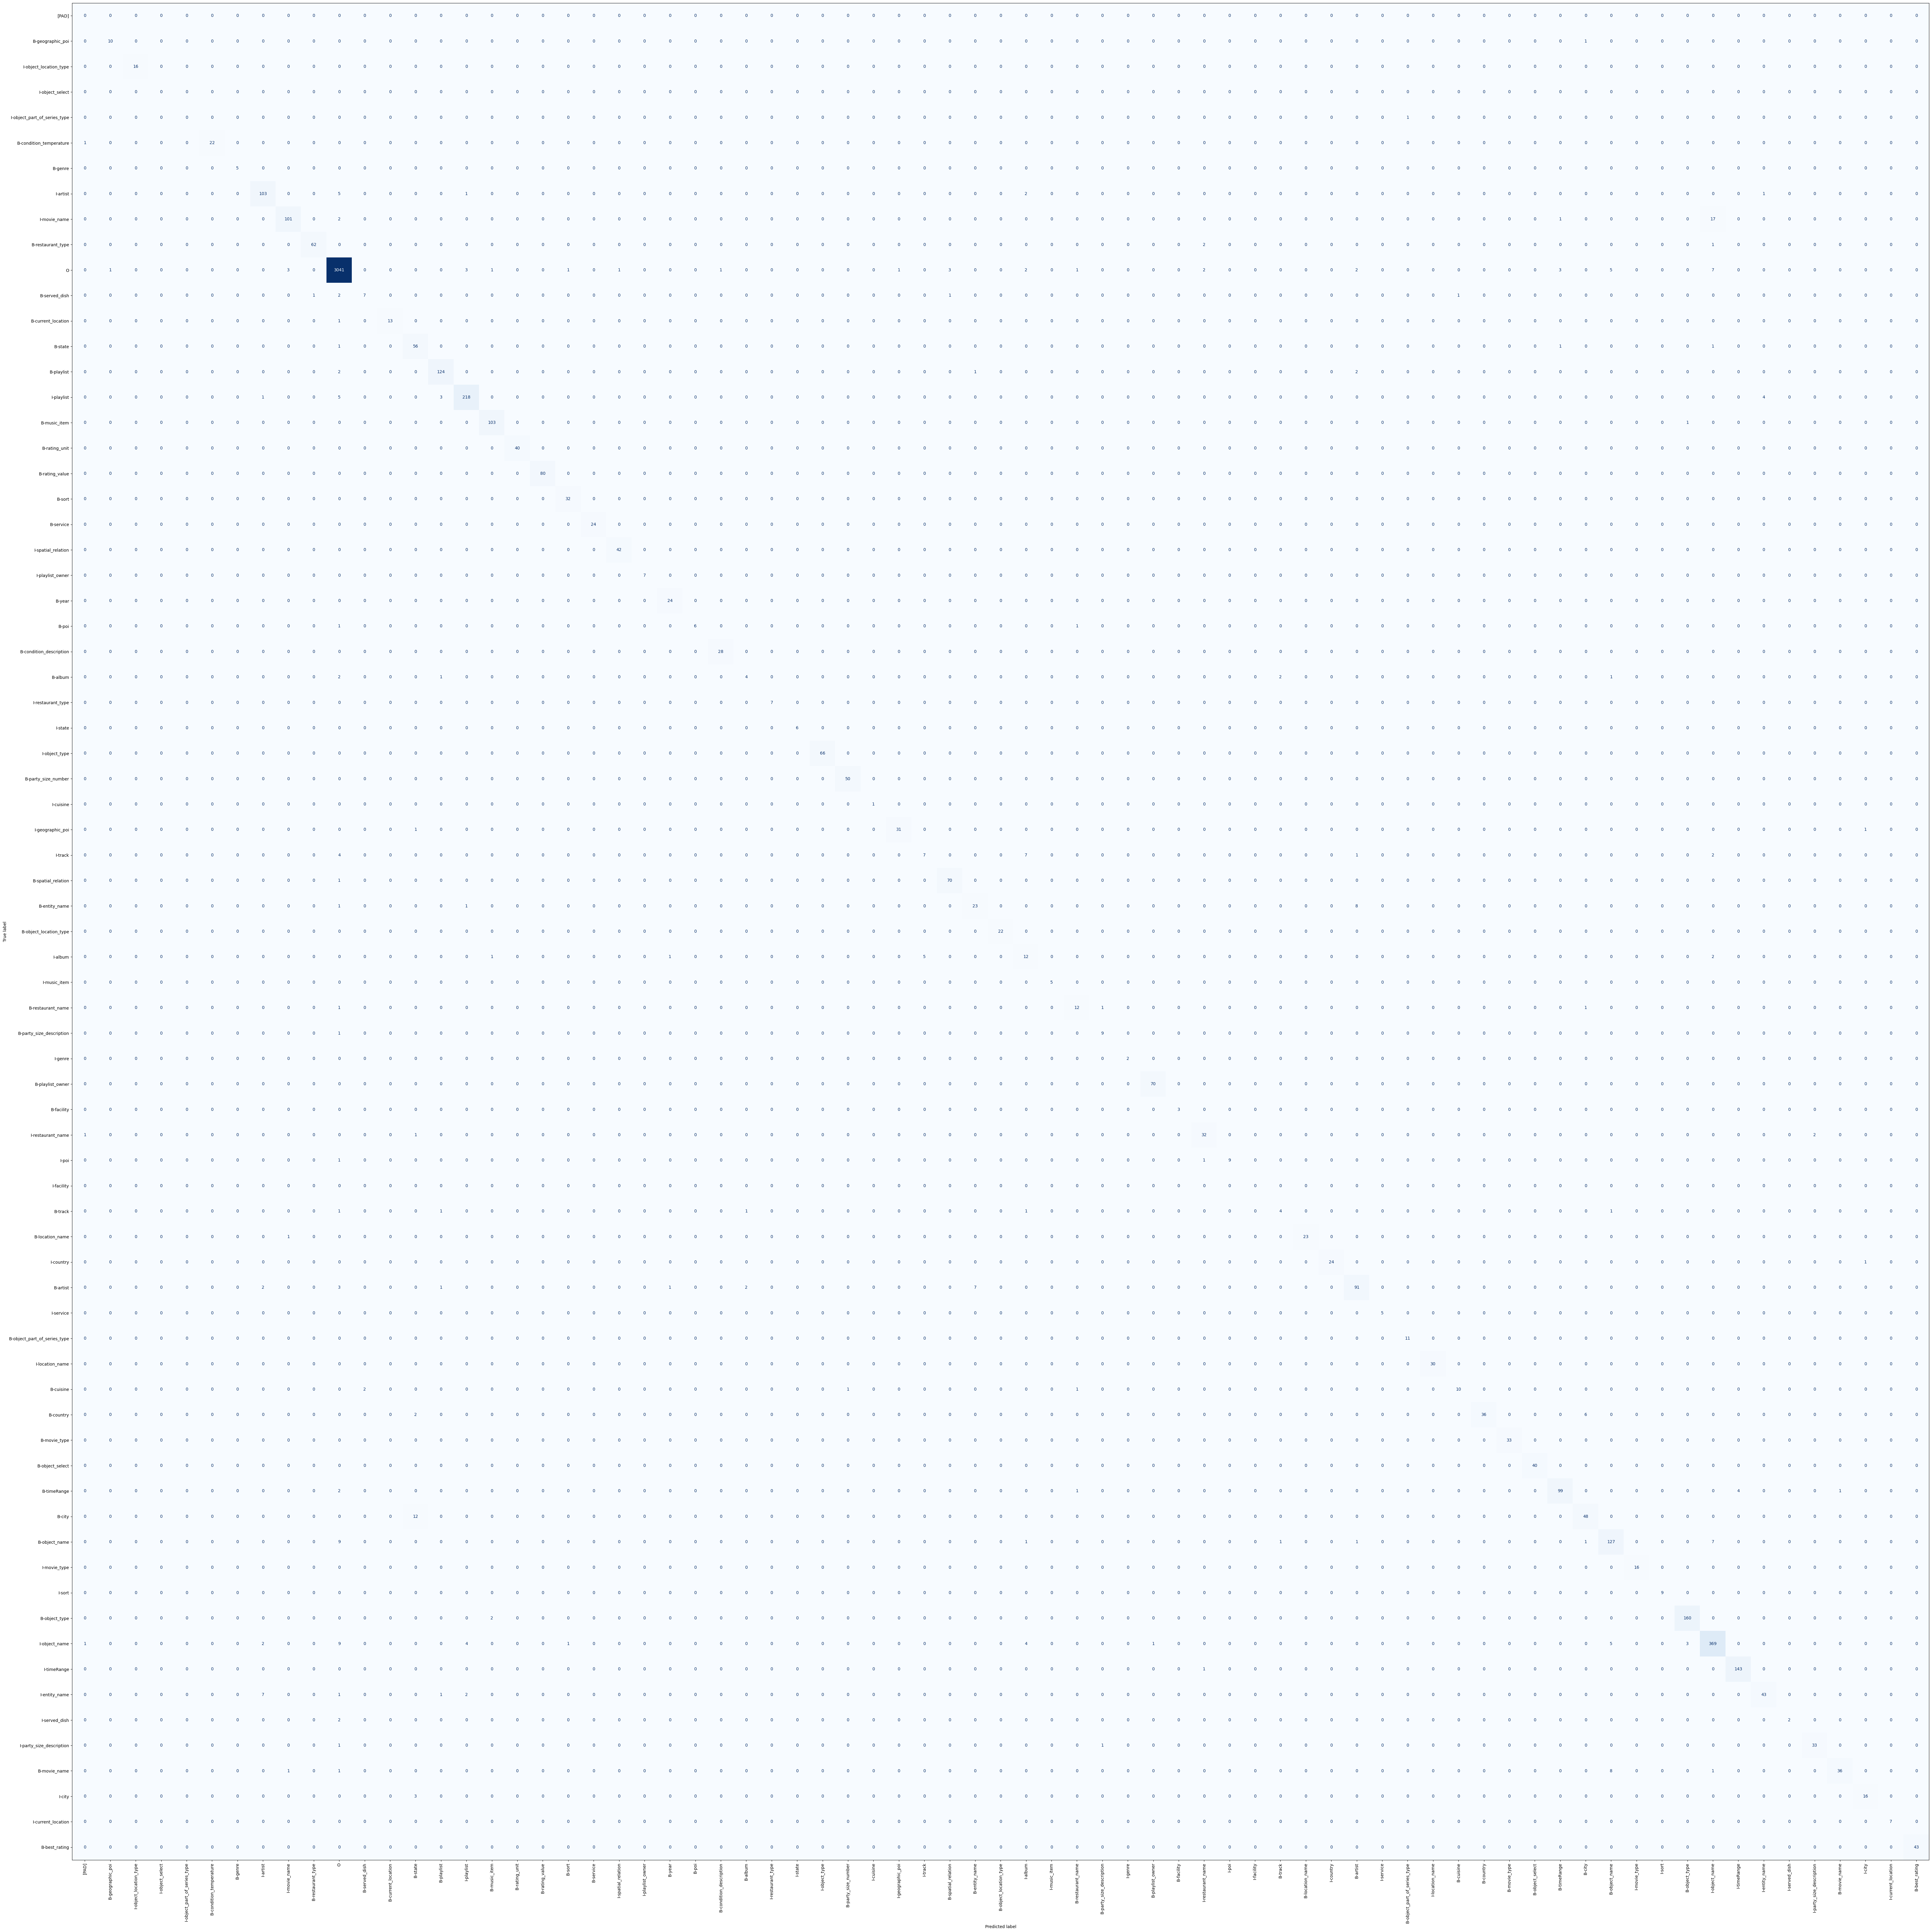

In [ ]:
show_training_results(params, lang)